Code taken from: https://github.com/pytorch/examples/tree/master/vae

In [2]:
## model imports
from __future__ import print_function
import argparse
import numpy as np
import os
import h5py
import pickle as pkl
import random
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## plot imports
import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import h5py
import matplotlib as mpl

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Section 0: Plotting

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             stdev_to_white=1,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
    initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
    mask = data_1dim > initial_mean
    mask = mask.astype(np.int)
    
    data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()

In [50]:
def cube_mass_histogram(cube=None,      ## array name
             edge_dim=128,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(20,10),
             stdev_to_white=1,
             norm_multiply=1,
             color_map="Blues",
             lognormal=False,
             hist_color="b",
                       hist_bins=300):
    
    ## adjust cube and get 1d array of in-cube masses
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    ## start plotting
    plt.figure(figsize=fig_size)
    plt.hist(data_1dim,bins=hist_bins,
            alpha=0.4)
    plt.xlabel("Masses")
    plt.ylabel("Number of Samples That Correspond to the Mass")
    plt.title("Output Mass Histogram")
    plt.show()

### Arguments

In [143]:
# modify to accept hard coded arguments
# batch_size = 8
batch_size = 16
# batch_size = 32
epochs = 20
no_cuda = False
log_interval = 1

cuda = not no_cuda and torch.cuda.is_available()
# cuda = False

seed = 1
torch.manual_seed(seed)


# device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

### Section 1: Sampling

In [141]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

In [7]:
def get_samples(s_sample, nsamples, redshift, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        ### datayi -1 1 arasina almayi dene
        
#         a = np.array(a) / max_cube
        a = np.array(a) / max_cube
        sample_array.append(a)
    
        counter = counter + 1
        
    f=0
    return sample_array

In [8]:
t_coords=define_test(1024,128)

In [9]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift
        
        self.samples = get_samples(s_sample = self.s_sample,
                             nsamples = self.nsamples,
                             redshift = self.redshift,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = self.samples[idx].reshape((1,128,128,128))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
#         sample = sample/1e6
#         sample = sample/1e6

        return sample

In [10]:
sampled_subcubes = HydrogenDataset2(h5_file="fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = 256, 
                                    redshift = "1.0")

The whole file size is 68719 MBs
Sampling finished.
Getting max value finished.
Counter = 1 / 256
Counter = 2 / 256
Counter = 3 / 256
Counter = 4 / 256
Counter = 5 / 256
Counter = 6 / 256
Counter = 7 / 256
Counter = 8 / 256
Counter = 9 / 256
Counter = 10 / 256
Counter = 11 / 256
Counter = 12 / 256
Counter = 13 / 256
Counter = 14 / 256
Counter = 15 / 256
Counter = 16 / 256
Counter = 17 / 256
Counter = 18 / 256
Counter = 19 / 256
Counter = 20 / 256
Counter = 21 / 256
Counter = 22 / 256
Counter = 23 / 256
Counter = 24 / 256
Counter = 25 / 256
Counter = 26 / 256
Counter = 27 / 256
Counter = 28 / 256
Counter = 29 / 256
Counter = 30 / 256
Counter = 31 / 256
Counter = 32 / 256
Counter = 33 / 256
Counter = 34 / 256
Counter = 35 / 256
Counter = 36 / 256
Counter = 37 / 256
Counter = 38 / 256
Counter = 39 / 256
Counter = 40 / 256
Counter = 41 / 256
Counter = 42 / 256
Counter = 43 / 256
Counter = 44 / 256
Counter = 45 / 256
Counter = 46 / 256
Counter = 47 / 256
Counter = 48 / 256
Counter = 49 / 25

In [11]:
type(sampled_subcubes)

__main__.HydrogenDataset2

### Section 2: Model and Data Loaders

In [12]:
# Data Loaders
train_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

test_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

#### Model

In [173]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        """
        The Encoding Layers
        nn.Conv3d 
        nn.MaxPool3d 
        
        out_channels is the number of different filters we convolute 
        over the whole sampled subcube.
        
        So the first convolutional layer's in_channel should be 0 (?)
        
        In addition, the next layer's in_channel should be equal to
        the previous layer's out_channels (all examples show that
        this is the case)
        """
        
#         self.fc1 = nn.Linear(784, 400)
#         self.fc21 = nn.Linear(400, 20)
#         self.fc22 = nn.Linear(400, 20)
#         self.fc3 = nn.Linear(20, 400)
#         self.fc4 = nn.Linear(400, 784)
        
        # Convolutional Layer 1
        self.encode_conv1 = nn.Conv3d(in_channels=1, 
                                      out_channels=8, 
                                      kernel_size=(4,4,4), # == 4
                                      stride = (2,2,2), # == 2
                                      padding=(1,1,1)) # == 1
        nn.init.xavier_uniform_(self.encode_conv1.weight) #Xaviers Initialisation
        
        self.encode_relu1 = nn.ReLU()
        
        ## CORRECT
        ####### KERNELLER
        self.encode_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)
        
        
        # Convolutional Layer 2
        self.encode_conv2 = nn.Conv3d(in_channels=8, 
                                      out_channels=16, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv2.weight) #Xaviers Initialisation
        
        self.encode_relu2 = nn.ReLU()
        self.encode_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)

        # Convolutional Layer 3
        self.encode_conv3 = nn.Conv3d(in_channels=16, 
                                      out_channels=32, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv3.weight) #Xaviers Initialisation
        
        self.encode_relu3 = nn.ReLU()
#         self.encode_maxpool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
#                                              stride=(2, 2, 2),
#                                             return_indices = True)

        
        
        """
        Fully Connected Layers after 3D Convolutional Layers
        First FC layer's input should be equal to 
        last convolutional layer's output
        8192 = 8^3 * 16 
            8^3 = (output of 2nd convolutional layer)
            16 = number of out_channels
        """
        
#         self.encode_fc1 = nn.Sequential(
#             nn.Linear(in_features=2048, 
#                       out_features=5096), 
#             nn.ReLU(),
#             nn.Dropout(0.5))
        
        self.encode_fc1_linear = nn.Linear(in_features=2048, ## 2048
                                           out_features=128)
        
        ## RELU TO LEAKY RELU
#         self.encode_fc1_relu = nn.ReLU()
        self.encode_LeakyReLU_1 = nn.LeakyReLU(negative_slope=-0.015)
    
        self.encode_fc1_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc1_linear.weight) #Xaviers Initialisation

        
#         self.encode_fc2 = nn.Sequential(
#             nn.Linear(in_features = 5096,
#                       out_features = 5096),
#             nn.ReLU(),
#             nn.Dropout(0.5))

        self.encode_fc2_linear = nn.Linear(in_features=128, 
                                           out_features=128)
    
        ## RELU TO LEAKY RELU
#         self.encode_fc2_relu = nn.ReLU()
        self.encode_LeakyReLU_2 = nn.LeakyReLU(negative_slope=-0.15)
    
        self.encode_fc2_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc2_linear.weight) #Xaviers Initialisation
        
        """
        The last fully connected layer's output is the dimensions
        of the embeddings?
        
        PyTorch VAE example uses output of 20 dimensions for mu &
        logvariance
        """
#         self.encode_fc31 = nn.Sequential(
#             nn.Linear(in_features=5096,
#                       out_features=20))
        
        self.encode_fc31_linear = nn.Linear(in_features=128, 
                                           out_features=16) ### burasi
        
        
        ## RELU TO LEAKY RELU
#         self.encode_fc31_relu = nn.ReLU()
        self.encode_LeakyReLU_31 = nn.LeakyReLU(negative_slope=-0.000015)
        
        self.encode_fc31_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc31_linear.weight) #Xaviers Initialisation

        
#         self.encode_fc32 = nn.Sequential(
#             nn.Linear(in_features=5096,
#                       out_features=20))
        ## out features daki 10 degisebilir - yukaridaki ile ayni olmali 
        self.encode_fc32_linear = nn.Linear(in_features=128, 
                                           out_features=16)
        
        ## RELU TO LEAKY RELU
#         self.encode_fc32_relu = nn.ReLU()
        self.encode_LeakyReLU_32 = nn.LeakyReLU(negative_slope=-0.000015)
        
        self.encode_fc32_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc32_linear.weight) #Xaviers Initialisation

        
        
        """
        The Decoding Layers
        nn.Conv3d -> nn.ConvTranspose3d
        nn.MaxPool3d -> nn.MaxUnpool3d
        """
        ## buradaki 10 degisebilir - latent gibi 
#         self.decode_fc1 = nn.Sequential(
#             nn.Linear(in_features=10,
#                       out_features=128))

        self.decode_fc1 = nn.Sequential(
            nn.Linear(in_features=16,
                      out_features=128))
        
        self.decode_fc2 = nn.Sequential(
            nn.Linear(in_features=128, 
                      out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.5))
        #init.xavier_normal(self.fc1.state_dict()['weight'])
        
        self.decode_fc3 = nn.Sequential(
            nn.Linear(in_features = 128,
                      out_features = 2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        #init.xavier_normal(self.fc2.state_dict()['weight'])
        
        
        self.decode_conv1 = nn.ConvTranspose3d(in_channels=32, 
                                              out_channels=16, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu1 = nn.ReLU()
        self.decode_maxunpool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        #init.xavier_normal(self.group1.state_dict()['weight'])
        
        self.decode_conv2 = nn.ConvTranspose3d(in_channels=16, 
                                              out_channels=8, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu2 = nn.ReLU()
        self.decode_maxunpool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        self.decode_conv3 = nn.ConvTranspose3d(in_channels=8, 
                                              out_channels=1, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu3 = nn.ReLU()
        self.decode_maxunpool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        self.decode_LeakyRelu1 = nn.LeakyReLU(negative_slope=-0.15)
        self.decode_LeakyRelu2 = nn.LeakyReLU(negative_slope=-0.15)
        self.decode_LeakyRelu3 = nn.LeakyReLU(negative_slope=-0.015)
        
        
    # Encoding part of VAE
    def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

        print("Starting Encoding")
#         print("----------------------------")
        
        out = self.encode_conv1(x)
#         print("First Conv output shape = " + str(out.shape))
        #print(out.shape)
        out = self.encode_relu1(out)
#         print("First ReLU Layer output shape = " + str(out.shape))
        size1 = out.size()
        out, ind1 = self.encode_maxpool1(out)
#         print("First MaxPooling output shape = " + str(out.shape))
#         print("Ind1 shape = " + str(ind1.shape))
#         #print("Size1 = " + str(size1))
#         print("----------------------------")
        
        out = self.encode_conv2(out)
#         print("Second Conv output shape = " + str(out.shape))
        out = self.encode_relu2(out)
#         print("Second ReLU Layer output shape = " + str(out.shape))
        size2 = out.size()
        out, ind2 = self.encode_maxpool2(out)
#         print("Second MaxPooling output shape = " + str(out.shape))
#         print("Ind2 shape = " + str(ind2.shape))
        #print("Size2 = " + str(size2))
#          print("----------------------------")
        
        out = self.encode_conv3(out)
#         print("Last Conv output shape = " + str(out.shape))
        out = self.encode_relu3(out)
#         print("Last ReLU output shape = " + str(out.shape))
        size3 = out.size()
#         out, ind3 = self.encode_maxpool3(out)
#         print("Last Conv Layer output shape = " + str(out.shape))
#         print("Ind3 shape = " + str(ind3.shape))
        #print("Size3 = " + str(size3))
#         print("----------------------------")

        """
        From here on, the convolutional layers' output is flattened
        into a rank 1 tensor of size x & put into a fully connected 
        network to output ??????
        
        https://github.com/pytorch/examples/blob/master/vae/main.py
        PyTorch's own example uses just 2 fully-connected layers
        to output mu and logvar predictions, below we use 3.
        """
        #out = out.view(out.size(0), -1)
        
        
        # batch_size = 1 - WORKS
#         out = out.view(1, -1)
        # batch_size != 1
        out = out.view(batch_size, -1)
        print(out.shape)
        
#         print("Last Conv Layer output shape after reshaping \n \
#                 (Input to first FC layer) = " + str(out.shape))
        
#         out = self.encode_fc1(out)
    
        out = self.encode_fc1_linear(out)
        
        ## RELU TO LEAKY RELU
#         out = self.encode_fc1_relu(out)
        out = self.encode_LeakyReLU_1(out)
        
        out = self.encode_fc1_dropout(out)
        
#         out = self.encode_fc2(out)

        out = self.encode_fc2_linear(out)
    
        ## RELU TO LEAKY RELU
#         out = self.encode_fc2_relu(out)
        out = self.encode_LeakyReLU_2(out)
        out = self.encode_fc2_dropout(out)
        
        
#         out_mu = self.encode_fc31(out)
        
        out_mu = self.encode_fc31_linear(out)
        
        ## RELU TO LEAKY RELU
#         out_mu = self.encode_fc31_relu(out_mu)
        out_mu = self.encode_LeakyReLU_31(out_mu)
        out_mu = self.encode_fc31_dropout(out_mu)
        
#         out_logvar = self.encode_fc32(out)

        out_logvar = self.encode_fc32_linear(out)
    
        ## RELU TO LEAKY RELU
#         out_logvar = self.encode_fc32_relu(out_logvar)
        out_logvar = self.encode_LeakyReLU_32(out_logvar)
        
        out_logvar = self.encode_fc32_dropout(out_logvar)
        
        print("Encode - Forward Pass Finished")
        print(out_mu.shape)
        print(out_logvar.shape)
#         print("----------------------------")
        
#         return out_mu, out_logvar, [ind1,ind2,ind3], [size1,size2,size3]
        return out_mu, out_logvar, [ind1,ind2], [size1,size2]
    

    # Reparametrization Trick
    def reparameterize(self, mu, logvar):
        """
        torch.exp = returns a new tensor with the exponential of 
                    the elements of input
        rand_like = returns a tensor with the same size as input
                    that is filled with random numbers from a normal
                    distribution with mean 0 and variance 1
        
        """
#         print("Reparametrization...")
#         print("logvar (in reparametrization) = \n" + str(logvar))
#         print("logvar (in reparametrization) = \n" + str(logvar*1e6))
#         print("mu * 1e6 (in reparametrization) = \n" + str(mu))
#         print("mu * 1e6 (in reparametrization) = \n" + str(mu*1e6))
        
        std = torch.exp(0.5*logvar)
#         std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        
#         print("0.5*logvar (in reparametrization) = \n" + str(0.5*logvar))
#         print("std (in reparametrization) = \n" + str(std))
#         print("eps (in reparametrization) = \n" + str(eps))
         
#         print("eps.mul(std).add_(mu) \n \
#                 [This is the output from reparameterize()] =\
#                     \n" + str(eps.mul(std).add_(mu)))
        
        return eps.mul(std).add_(mu)
    
    
    # Decoding part of VAE
    def decode(self, z, indices_list, size_list):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
#         print("----------------------------")
        print("Starting Decoding")
#         print("z shape = " + str(z.shape))
        
        ### buradaki butun outlarin sumlarina bak 
        out = self.decode_fc1(z)
#         print("1st FC output shape = " + str(out.shape))
        out = self.decode_fc2(out)
#         print("2nd FC output shape = " + str(out.shape))
        out = self.decode_fc3(out)
#         print("Last FC output shape = " + str(out.shape))
        
        # batch_size = 1 - WORKS
#         out = out.view(1, 32, 4, 4, 4)
        # batch_size != 1 
        out = out.view(batch_size, 32, 4, 4, 4)        
        print ("FIRST DECODE OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
#         print("First Deconv input shape = " + str(out.shape))
#         print("After last convolution (encoding stage) output shape = " +\
#                   str(indices_list[1].shape))
        out = self.decode_conv1(out)
        print ("CONV 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First Deconv output shape = " + str(out.shape))
        
        ## RELU TO LEAKY RELU
#         out = self.decode_relu1(out)
        out = self.decode_LeakyRelu1(out)
        print ("RELU 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First ReLU output shape = " + str(out.shape))
        # maxunpooling needs indices

#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[1])
        out = self.decode_maxunpool1(out,
                                     indices = indices_list[1],
                                     output_size = size_list[1])
        print ("MAX UNPOOL 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd MaxUnpool ouput shape = " + str(out.shape))
        
        out = self.decode_conv2(out)
        print ("CONV 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd Deconv output shape = " + str(out.shape))

        ## RELU TO LEAKY RELU
#         out = self.decode_relu2(out)
        out = self.decode_LeakyRelu2(out)
        print ("RELU 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd ReLU output shape = " + str(out.shape))
        out = self.decode_maxunpool1(out,
                     indices = indices_list[0])
        print ("MAX UNPOOL 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[1],
#                                      output_size = size_list[1])
        
        out = self.decode_conv3(out)
        print ("CONV 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        ## RELU TO LEAKY RELU
#         out = self.decode_relu3(out)
        out = self.decode_LeakyRelu3(out)
        print ("RELU 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("Last ReLU output shape = " + str(out.shape))
#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[0])
        # there is no last maxunpool in https://github.com/pgtgrly/Convolution-Deconvolution-Network-Pytorch/blob/master/Neural_Network_Class.py
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[0],
#                                      output_size = size_list[0])
        
        return out
    

    # Forward Pass
    def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, 784))
        mu, logvar, indices_list, size_list = self.encode(x)
#         print("logvar (after encoding) = \n" + str(logvar))
#         print("mu (after encoding) = \n" + str(mu))
        
        z = self.reparameterize(mu, logvar)
#         print("z = ")
#         print(z)
        reconstructed_x = self.decode(z, indices_list, size_list)
    
        return reconstructed_x , mu, logvar
       

In [174]:
model = VAE().to(device)

In [175]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001,
                      weight_decay=0.01) ## change learning rate

#### Loss Function

In [176]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
#     print("--------------------------------------")
#     print("Calculating Loss...")
#     print("recon_x shape = " + str(recon_x.shape))
    
#     BCE = F.binary_cross_entropy(recon_x, 
#                                  x.view(-1, 1, 128, 128, 128), 
#                                  reduction='sum')
#     print("BCE Loss = " + str(BCE))


    """
    https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
    This article is about reconstructing MNIST dataset (2D images with 1 channels)
    And it uses squared difference for the reconstruction loss, thus
    it is safe to say that for 3D reconstruction we might use the same thing too.
    
    But the MSE loss seems to be around 1e20 magnitude, thus suggesting some
    bug might exist in it.
    The multplication by 1e12 is because of the 1e6 division when loading
    the dataset
    """
    MSE = F.mse_loss(recon_x, 
                     x.view(-1, 1, 128, 128, 128), 
                     reduction='sum') * 1e12 
    
    print("MSE Loss = " + str(MSE))

    """
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    # https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
    # normalises the KLD loss by batch_size
    """
#     print("logvar (KLD Loss) = \n" + str(logvar))
#     print("mu (KLD Loss) = \n" + str(mu))
#     print("logvar.exp() (KLD Loss) = \n" + str(logvar.exp()))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = KLD / float(batch_size)
    print("KLD Loss = " + str(KLD))

    
#     return MSE
#     return BCE
#     return BCE + KLD
    return MSE + KLD

#### Train and Test Epochs

In [177]:
def train(epoch):
    model.train()
    train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
    for batch_idx, data in enumerate(train_loader):
#         print(batch_idx)
#         print(data)
        
        #print("Batch size = " + str(data.shape))
        
        data = data.to(device)
        print("Data transfer to device completed.")
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
#         print("Reconstructed Input = \n " + str(recon_batch))
#         print("Real Input = \n " + str(data))
#         print("Reconstructed Input Shape = \n " + str(recon_batch.shape))
#         print("Real Input Shape = \n " + str(data.shape))

#         print("logvar = \n" + str(logvar))
#         print("mu = \n" + str(mu))

        # Plotting Input Cube
        print("data shape = " + str(data.view(-1,128,128,128).shape))
        print("data shape = " + str(data[0].cpu().view(128,128,128).numpy().shape))

        if epoch % (epochs / 4) == 0 and batch_idx == 0:
#             visualize_cube(cube=data[0].cpu().view(128,128,128).detach().numpy(),
#                            edge_dim = 128,
#                            start_cube_index_x = 0,
#                           start_cube_index_y = 0,
#                           start_cube_index_z = 0,
#                           fig_size = (20,20),
#                           stdev_to_white = 1,
#                           norm_multiply = 1000,
#                           color_map = "Blues",
#                           lognormal = False)
            
            cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
            print ("Output mass sum (original): "\
                   + str(np.sum(data[0].cpu().view(128,128,128).detach().numpy())))
        
        # Plotting Reconstructed Cube
        print("reconstructed cube = " + \
              str(recon_batch.view(-1,128,128,128).shape))
        print("reconstructed cube = " + \
              str(recon_batch[0].view(128,128,128).shape))


        if epoch % (epochs / 4) == 0 and batch_idx == 0:
            visualize_cube(cube=recon_batch[0].cpu().view(128,128,128).detach().numpy(),
                           edge_dim = 128,
                           start_cube_index_x = 0,
                          start_cube_index_y = 0,
                          start_cube_index_z = 0,
                          fig_size = (20,20),
                          stdev_to_white = 1,
                          norm_multiply = 1000,
                          color_map = "Blues",
                          lognormal = False)
            
            cube_mass_histogram(cube=recon_batch[0].cpu().view(128,128,128).detach().numpy())
            print ("Output mass sum (reconstructed batch): "\
                   + str(np.sum(recon_batch[0].cpu().view(128,128,128).detach().numpy())))
        
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        
        loss_history.append(loss.item())
        
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.12f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [178]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
        for k, data in enumerate(test_loader):
            print("k = " + str(k))
        
            data = data.to(device)
            
            # Plotting Input Cube
            print("data shape = " + str(data.view(-1,128,128,128).shape))
            print("data shape = " + str(data[0].view(128,128,128).shape))
  
            if epoch % (epochs / 4) == 0 and k == 0:
                visualize_cube(cube=data[0].view(128,128,128),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = 1,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
            
            recon_batch, mu, logvar = model(data)
            
            # Plotting Reconstructed Cube
            print("reconstructed cube = " + \
                  str(recon_batch.view(-1,128,128,128).shape))
            print("reconstructed cube = " + \
                  str(recon_batch[0].view(128,128,128).shape))
            
            if epoch % (epochs / 4) == 0 and k == 0:
                visualize_cube(cube=recon_batch[0].view(128,128,128),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = 1,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
            
            
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

#             if k == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n], 
#                                         recon_batch.view(batch_size, 1, 128, 128, 128)[:n]])
                                      #recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                                         recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.12f}'.format(test_loss))

### Start Training

Epoch = 1 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 2549.5244
CONV 1 OUT SUM = 162.86261
RELU 1 OUT SUM = 2163.9756
MAX UNPOOL 1 OUT SUM = 2163.9756
CONV 2 OUT SUM = -33063.906
RELU 2 OUT SUM = 19956.252
MAX UNPOOL 2 OUT SUM = 19956.254
CONV 3 OUT SUM = -930312.1
RELU 3 OUT SUM = 13954.744
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(7630520057856., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1090, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [0/256 (0%)]	Loss: 476907503616.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE

MAX UNPOOL 2 OUT SUM = 87415.46
CONV 3 OUT SUM = -532884.0
RELU 3 OUT SUM = 8006.988
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(3546787348480., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(7.2544, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [160/256 (62%)]	Loss: 221674209280.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 8171.6846
CONV 1 OUT SUM = 29830.854
RELU 1 OUT SUM = 35829.133
MAX UNPOOL 1 OUT SUM = 35829.133
CONV 2 OUT SUM = -140305.89
RELU 2 OUT SUM = 87295.92
MAX UNPOOL 2 OUT SUM = 87295.94
CONV 3 OUT SUM = -497135.78
RELU 3 OUT SUM = 7473.972
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([1

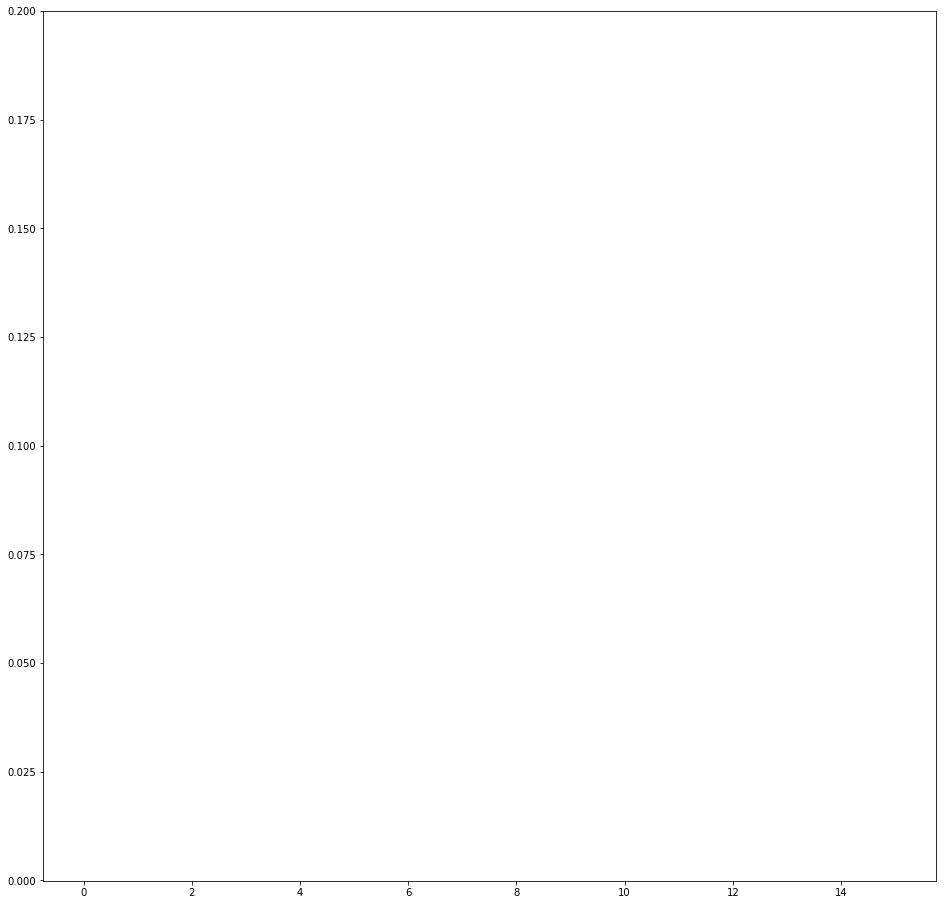

Epoch = 2 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 6978.1636
CONV 1 OUT SUM = 23186.904
RELU 1 OUT SUM = 28509.432
MAX UNPOOL 1 OUT SUM = 28509.424
CONV 2 OUT SUM = -169369.08
RELU 2 OUT SUM = 84331.664
MAX UNPOOL 2 OUT SUM = 84331.58
CONV 3 OUT SUM = -336647.22
RELU 3 OUT SUM = 5060.156
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2066809356288., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.5535, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 2 [0/256 (0%)]	Loss: 129175584768.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE 

MAX UNPOOL 2 OUT SUM = 59361.254
CONV 3 OUT SUM = -140827.75
RELU 3 OUT SUM = 2140.3137
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2970173308928., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.2142, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 2 [160/256 (62%)]	Loss: 185635831808.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 6876.6562
CONV 1 OUT SUM = 6879.5513
RELU 1 OUT SUM = 12450.062
MAX UNPOOL 1 OUT SUM = 12450.062
CONV 2 OUT SUM = -155739.67
RELU 2 OUT SUM = 56199.41
MAX UNPOOL 2 OUT SUM = 56199.4
CONV 3 OUT SUM = -128491.14
RELU 3 OUT SUM = 1951.1752
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size

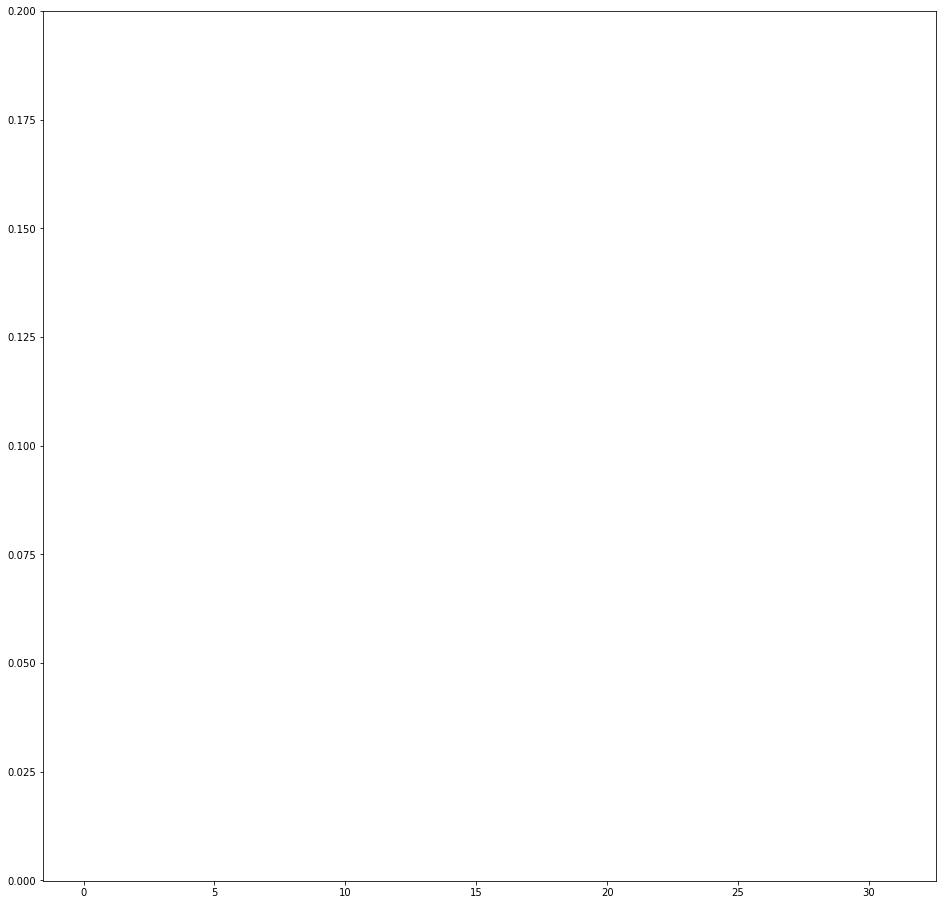

Epoch = 3 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 6452.1064
CONV 1 OUT SUM = 1470.242
RELU 1 OUT SUM = 7971.513
MAX UNPOOL 1 OUT SUM = 7971.512
CONV 2 OUT SUM = -139957.88
RELU 2 OUT SUM = 46341.19
MAX UNPOOL 2 OUT SUM = 46341.15
CONV 3 OUT SUM = -78555.914
RELU 3 OUT SUM = 1216.1692
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1686959947776., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.2123, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 3 [0/256 (0%)]	Loss: 105434996736.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT

MAX UNPOOL 2 OUT SUM = 32089.418
CONV 3 OUT SUM = -49324.125
RELU 3 OUT SUM = 756.0079
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2418796658688., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1673, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 3 [160/256 (62%)]	Loss: 151174791168.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5895.681
CONV 1 OUT SUM = -6457.964
RELU 1 OUT SUM = 3586.2388
MAX UNPOOL 1 OUT SUM = 3586.2395
CONV 2 OUT SUM = -116514.63
RELU 2 OUT SUM = 31221.062
MAX UNPOOL 2 OUT SUM = 31221.023
CONV 3 OUT SUM = -47817.668
RELU 3 OUT SUM = 730.98816
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Siz

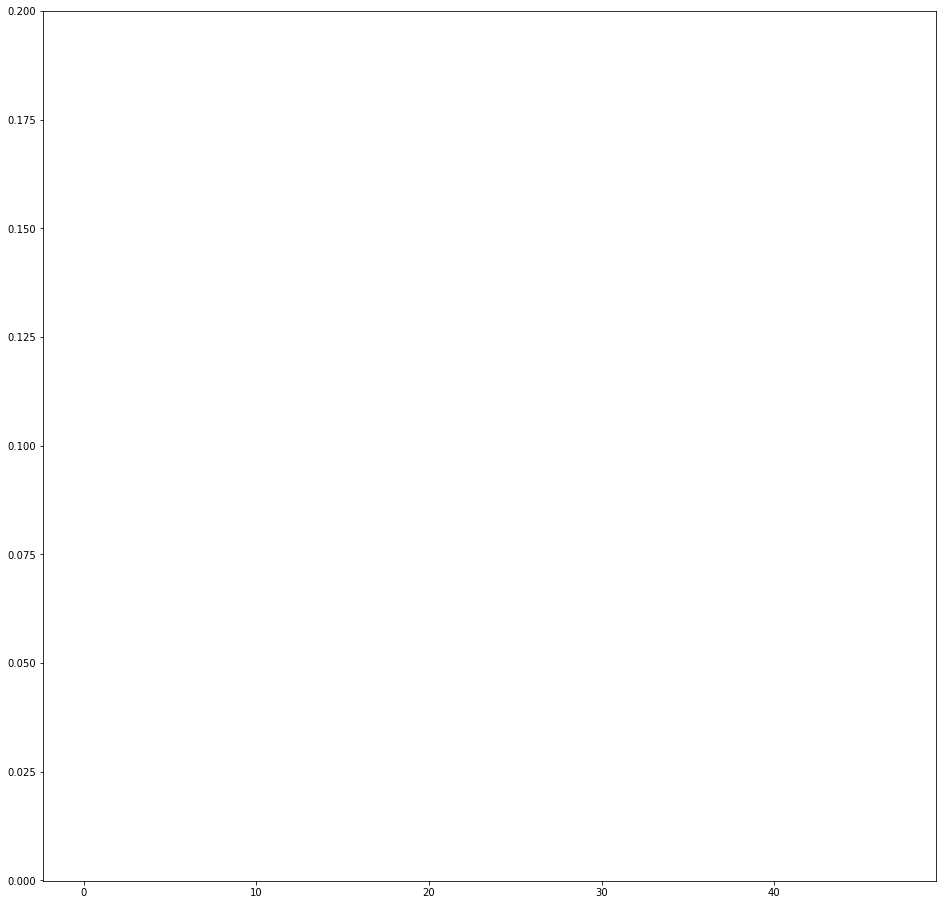

Epoch = 4 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5912.422
CONV 1 OUT SUM = -8387.738
RELU 1 OUT SUM = 3274.5686
MAX UNPOOL 1 OUT SUM = 3274.5693
CONV 2 OUT SUM = -115067.47
RELU 2 OUT SUM = 28651.682
MAX UNPOOL 2 OUT SUM = 28651.69
CONV 3 OUT SUM = -37599.074
RELU 3 OUT SUM = 580.8988
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2407955693568., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1618, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 4 [0/256 (0%)]	Loss: 150497230848.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE O

MAX UNPOOL 2 OUT SUM = 25062.559
CONV 3 OUT SUM = -26883.861
RELU 3 OUT SUM = 418.7238
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1097092890624., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1829, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 4 [160/256 (62%)]	Loss: 68568305664.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5474.539
CONV 1 OUT SUM = -9722.073
RELU 1 OUT SUM = 2816.6333
MAX UNPOOL 1 OUT SUM = 2816.6335
CONV 2 OUT SUM = -109898.04
RELU 2 OUT SUM = 24733.816
MAX UNPOOL 2 OUT SUM = 24733.844
CONV 3 OUT SUM = -27021.83
RELU 3 OUT SUM = 419.69714
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size(

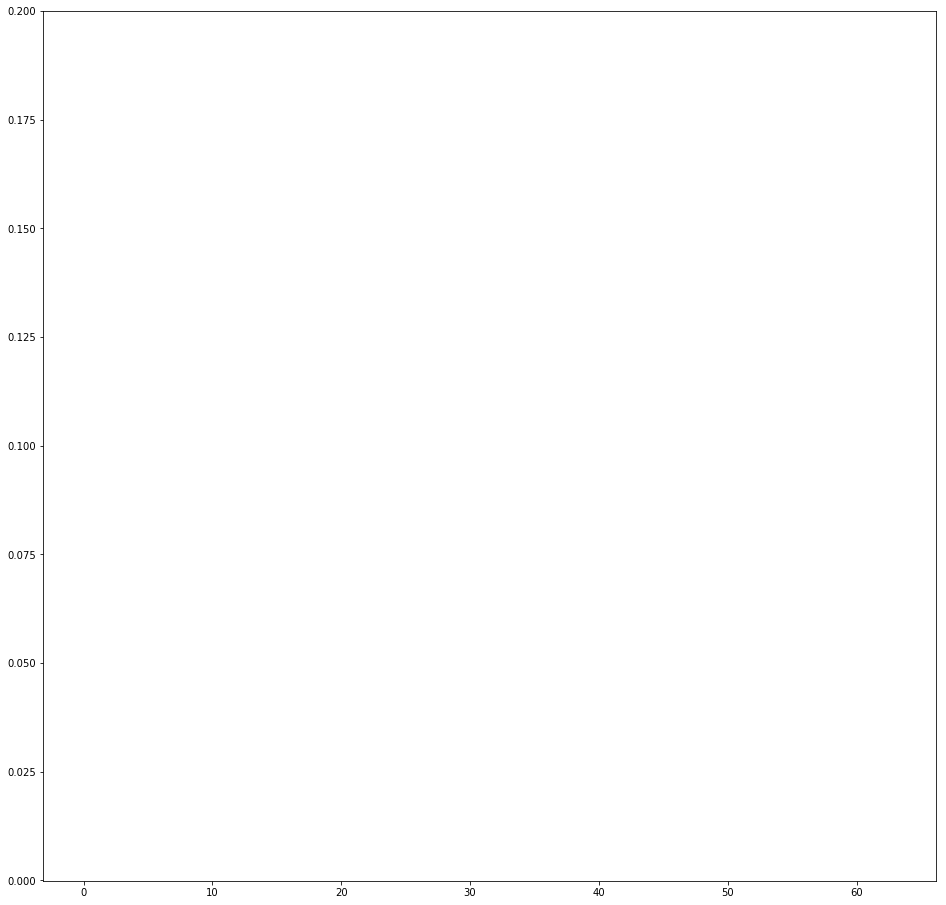

Epoch = 5 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5371.6177
CONV 1 OUT SUM = -10053.982
RELU 1 OUT SUM = 2754.7527
MAX UNPOOL 1 OUT SUM = 2754.7537
CONV 2 OUT SUM = -108103.98
RELU 2 OUT SUM = 23653.912
MAX UNPOOL 2 OUT SUM = 23653.867
CONV 3 OUT SUM = -23734.95
RELU 3 OUT SUM = 368.594
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)


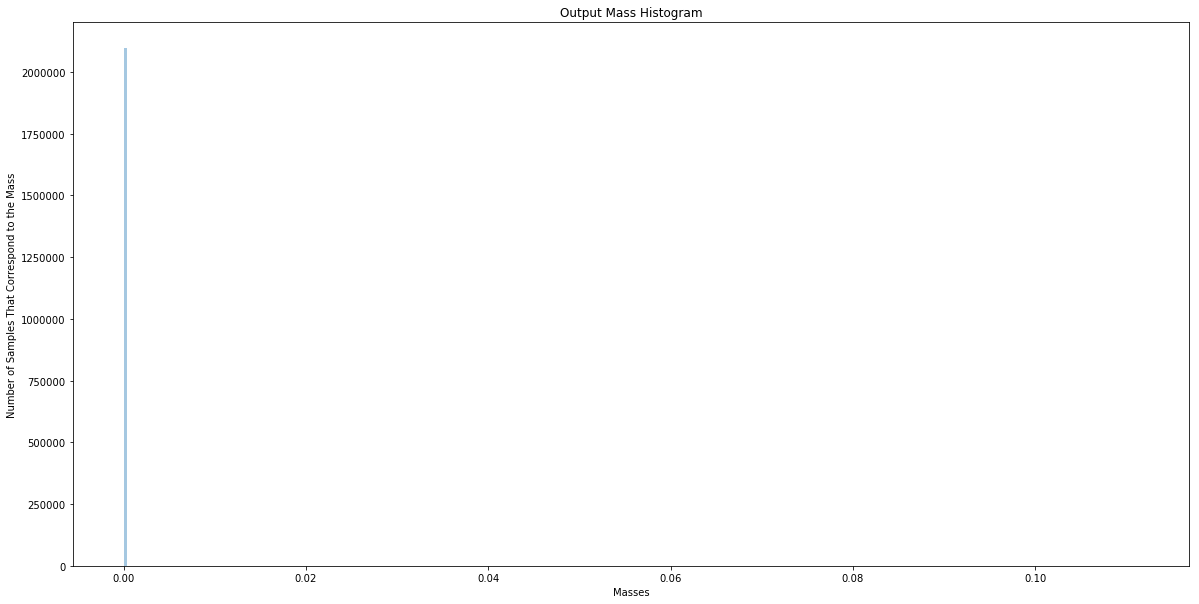

Output mass sum (original): 1.502128
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])


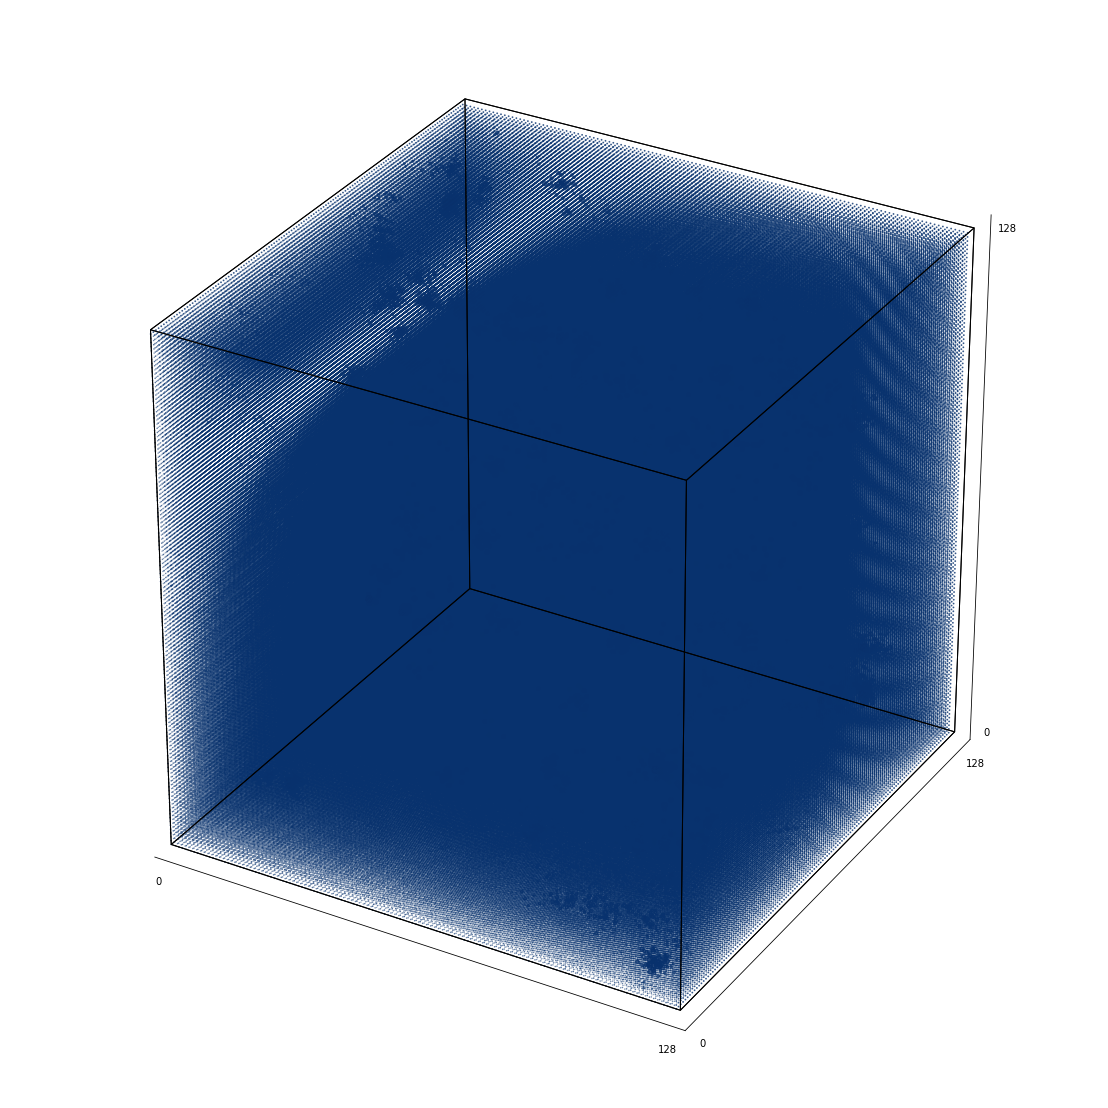

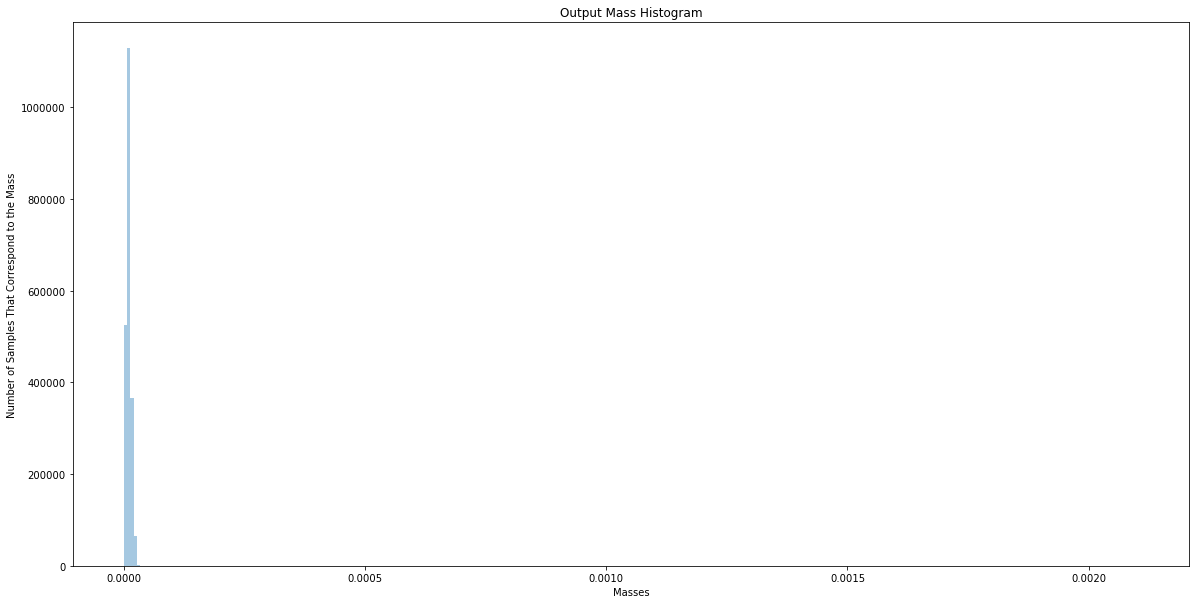

Output mass sum (reconstructed batch): 24.191387
MSE Loss = tensor(526046035968., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1594, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 5 [0/256 (0%)]	Loss: 32877877248.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5486.214
CONV 1 OUT SUM = -10418.553
RELU 1 OUT SUM = 2769.6055
MAX UNPOOL 1 OUT SUM = 2769.606
CONV 2 OUT SUM = -108121.97
RELU 2 OUT SUM = 23556.543
MAX UNPOOL 2 OUT SUM = 23556.566
CONV 3 OUT SUM = -22429.004
RELU 3 OUT SUM = 359.36554
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(779320295424., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1561, device='cuda:0', grad_fn=<DivBackward0>)
Train E

Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4659.328
CONV 1 OUT SUM = -9125.064
RELU 1 OUT SUM = 2323.2095
MAX UNPOOL 1 OUT SUM = 2323.2095
CONV 2 OUT SUM = -103093.76
RELU 2 OUT SUM = 22365.729
MAX UNPOOL 2 OUT SUM = 22365.73
CONV 3 OUT SUM = -18757.566
RELU 3 OUT SUM = 306.3162
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2447673655296., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1416, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 5 [176/256 (69%)]	Loss: 152979603456.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 559

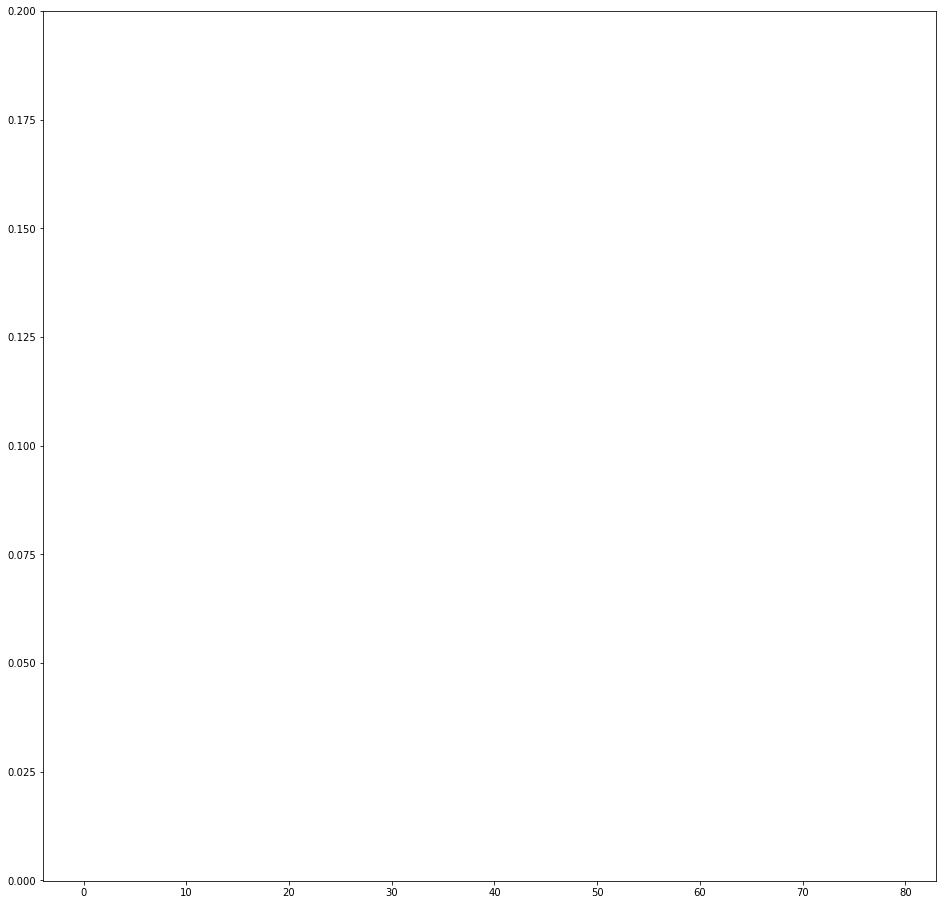

Epoch = 6 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4861.658
CONV 1 OUT SUM = -9618.398
RELU 1 OUT SUM = 2373.1907
MAX UNPOOL 1 OUT SUM = 2373.1907
CONV 2 OUT SUM = -102443.875
RELU 2 OUT SUM = 21989.287
MAX UNPOOL 2 OUT SUM = 21989.287
CONV 3 OUT SUM = -18669.229
RELU 3 OUT SUM = 308.0327
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(4362258874368., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1685, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 6 [0/256 (0%)]	Loss: 272641179648.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE

CONV 3 OUT SUM = -16519.04
RELU 3 OUT SUM = 271.90714
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(850851266560., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1930, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 6 [160/256 (62%)]	Loss: 53178204160.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4847.2954
CONV 1 OUT SUM = -9780.362
RELU 1 OUT SUM = 2334.2175
MAX UNPOOL 1 OUT SUM = 2334.2178
CONV 2 OUT SUM = -102543.34
RELU 2 OUT SUM = 21528.334
MAX UNPOOL 2 OUT SUM = 21528.326
CONV 3 OUT SUM = -16392.686
RELU 3 OUT SUM = 269.1937
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructe

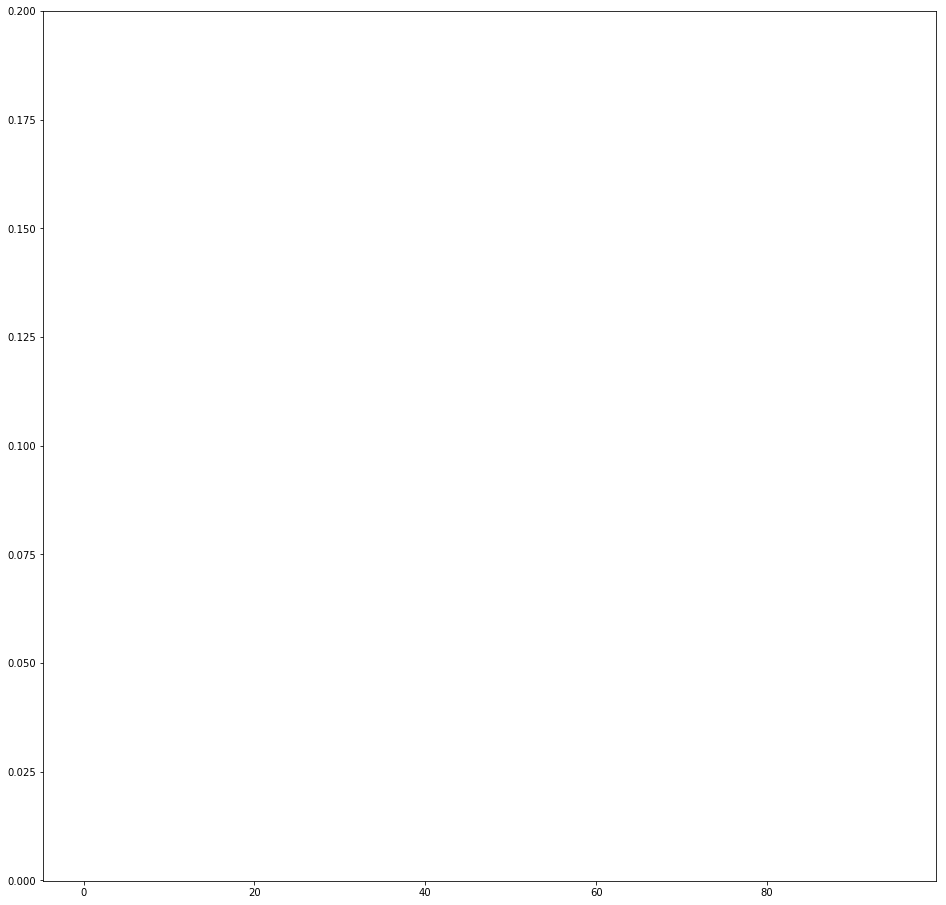

Epoch = 7 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4800.734
CONV 1 OUT SUM = -9723.969
RELU 1 OUT SUM = 2312.3853
MAX UNPOOL 1 OUT SUM = 2312.3853
CONV 2 OUT SUM = -102130.14
RELU 2 OUT SUM = 21192.604
MAX UNPOOL 2 OUT SUM = 21192.562
CONV 3 OUT SUM = -18049.371
RELU 3 OUT SUM = 280.93185
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1017054429184., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1221, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 7 [0/256 (0%)]	Loss: 63565901824.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE 

CONV 3 OUT SUM = -13229.323
RELU 3 OUT SUM = 257.8939
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(3686215450624., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1803, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 7 [160/256 (62%)]	Loss: 230388465664.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5371.16
CONV 1 OUT SUM = -11405.718
RELU 1 OUT SUM = 2629.164
MAX UNPOOL 1 OUT SUM = 2629.164
CONV 2 OUT SUM = -106189.21
RELU 2 OUT SUM = 21384.643
MAX UNPOOL 2 OUT SUM = 21384.639
CONV 3 OUT SUM = -13138.439
RELU 3 OUT SUM = 242.48605
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructe

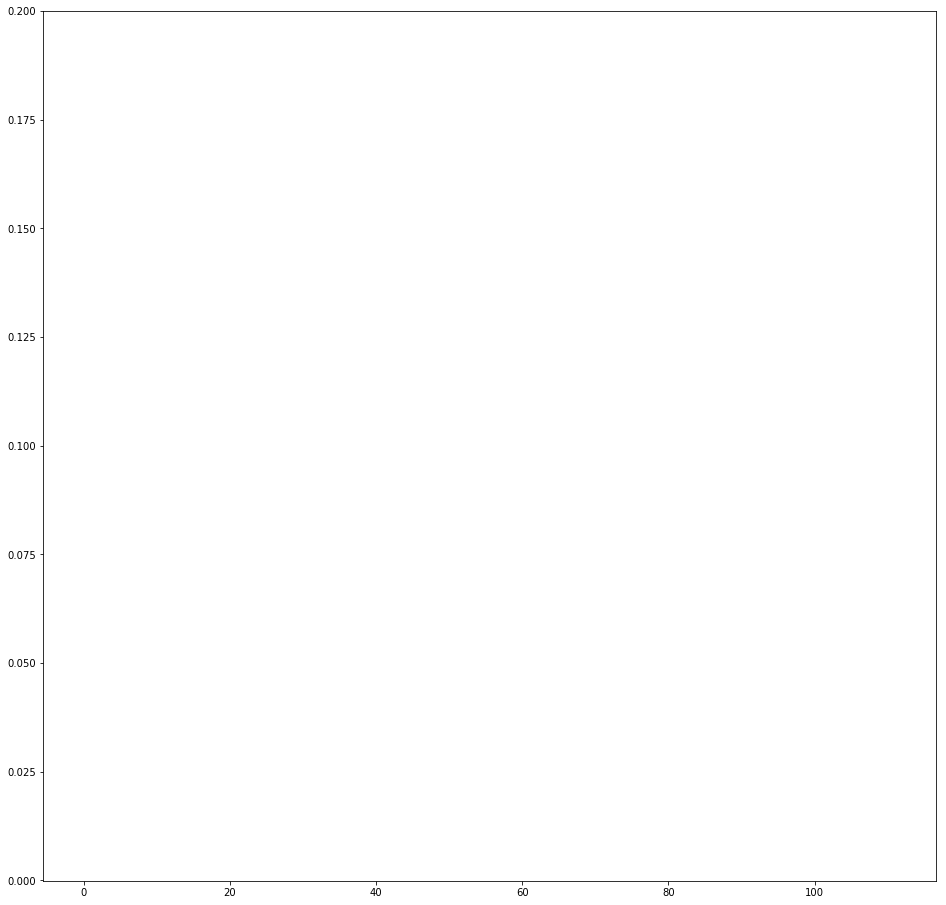

Epoch = 8 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4692.1426
CONV 1 OUT SUM = -10026.09
RELU 1 OUT SUM = 2320.4326
MAX UNPOOL 1 OUT SUM = 2320.4321
CONV 2 OUT SUM = -103913.4
RELU 2 OUT SUM = 21108.951
MAX UNPOOL 2 OUT SUM = 21108.93
CONV 3 OUT SUM = -19747.84
RELU 3 OUT SUM = 314.3834
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1689312428032., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1689, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 8 [0/256 (0%)]	Loss: 105582026752.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OU

CONV 3 OUT SUM = -16251.845
RELU 3 OUT SUM = 273.76337
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2786627944448., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1497, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 8 [160/256 (62%)]	Loss: 174164246528.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5330.175
CONV 1 OUT SUM = -12046.078
RELU 1 OUT SUM = 2697.903
MAX UNPOOL 1 OUT SUM = 2697.903
CONV 2 OUT SUM = -109624.875
RELU 2 OUT SUM = 21772.371
MAX UNPOOL 2 OUT SUM = 21772.389
CONV 3 OUT SUM = -16664.328
RELU 3 OUT SUM = 274.62183
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstru

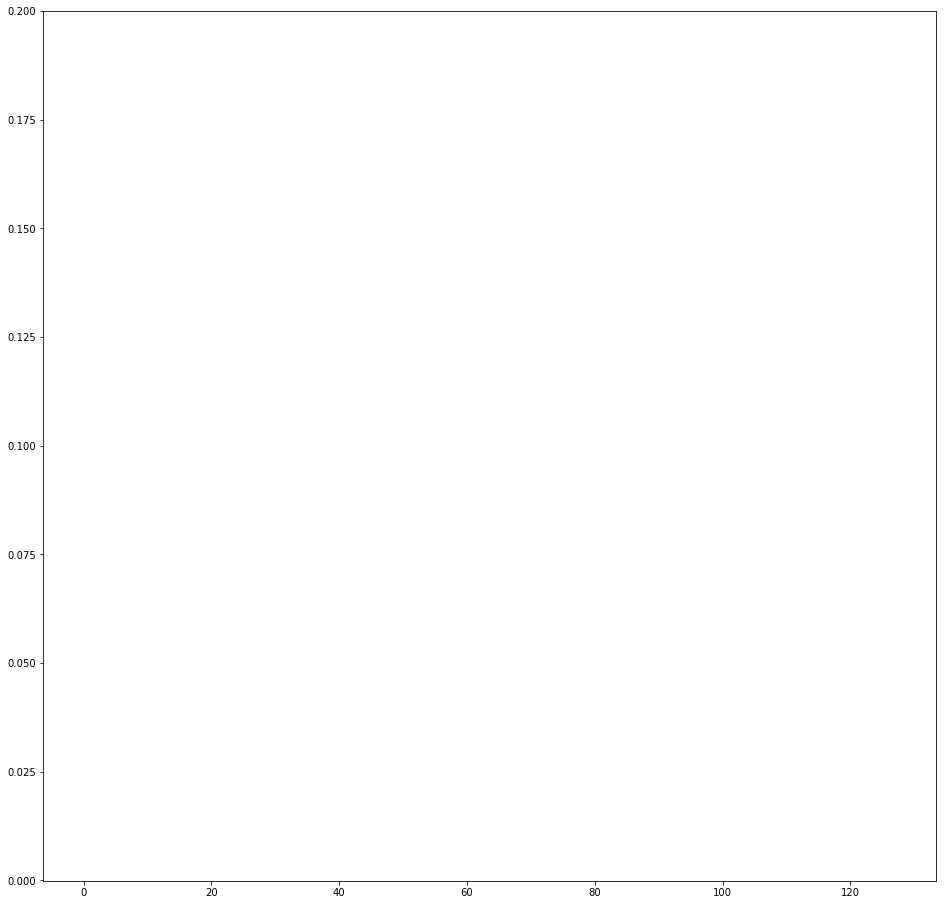

Epoch = 9 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4765.303
CONV 1 OUT SUM = -11070.098
RELU 1 OUT SUM = 2511.8936
MAX UNPOOL 1 OUT SUM = 2511.8933
CONV 2 OUT SUM = -109702.05
RELU 2 OUT SUM = 21734.701
MAX UNPOOL 2 OUT SUM = 21734.719
CONV 3 OUT SUM = -19449.105
RELU 3 OUT SUM = 312.23676
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2487573544960., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1625, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 9 [0/256 (0%)]	Loss: 155473346560.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECOD

CONV 3 OUT SUM = -20112.033
RELU 3 OUT SUM = 318.40823
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(938771677184., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1957, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 9 [160/256 (62%)]	Loss: 58673229824.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4924.168
CONV 1 OUT SUM = -11940.508
RELU 1 OUT SUM = 2706.9517
MAX UNPOOL 1 OUT SUM = 2706.9521
CONV 2 OUT SUM = -114114.37
RELU 2 OUT SUM = 22111.432
MAX UNPOOL 2 OUT SUM = 22111.412
CONV 3 OUT SUM = -20550.541
RELU 3 OUT SUM = 341.92273
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstruc

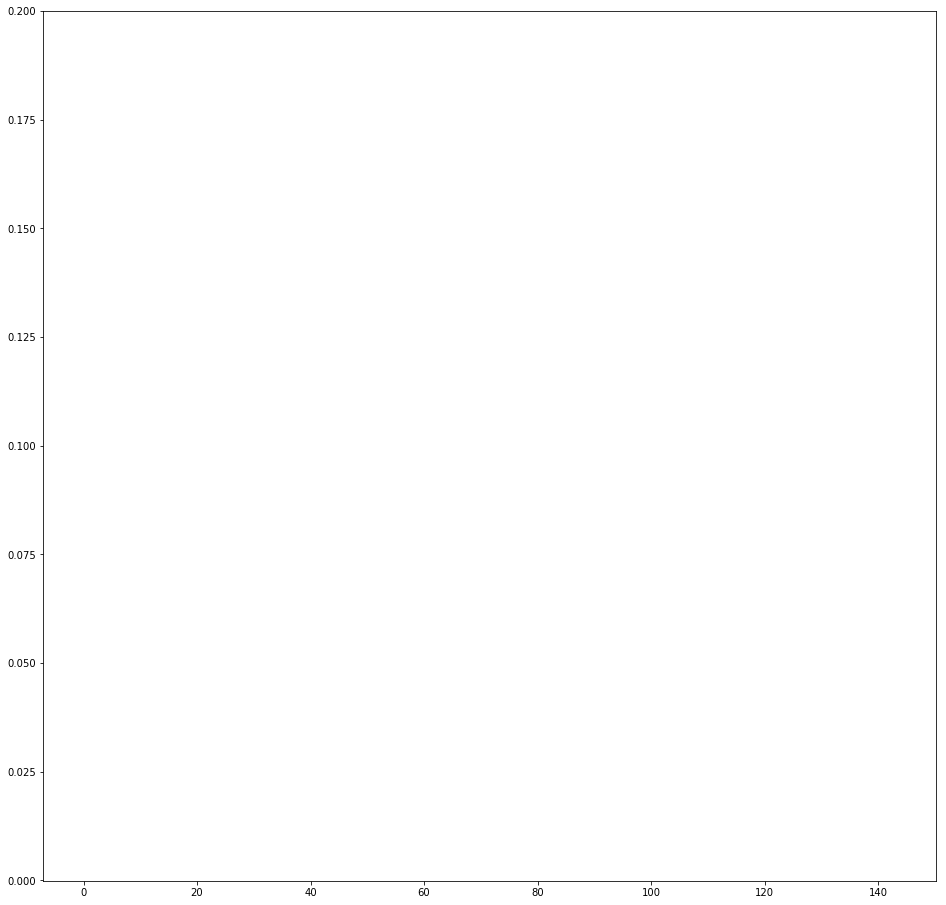

Epoch = 10 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4712.7417
CONV 1 OUT SUM = -11462.802
RELU 1 OUT SUM = 2683.4004
MAX UNPOOL 1 OUT SUM = 2683.4004
CONV 2 OUT SUM = -116390.1
RELU 2 OUT SUM = 22555.879
MAX UNPOOL 2 OUT SUM = 22555.88
CONV 3 OUT SUM = -18640.629
RELU 3 OUT SUM = 319.06744
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)


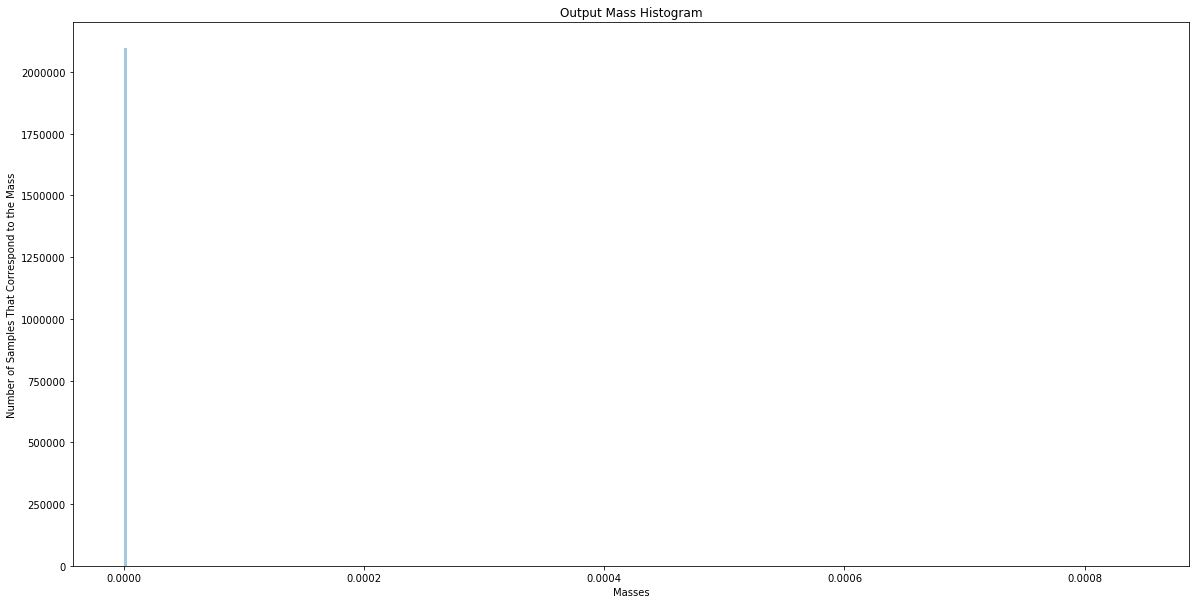

Output mass sum (original): 0.01515733
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])


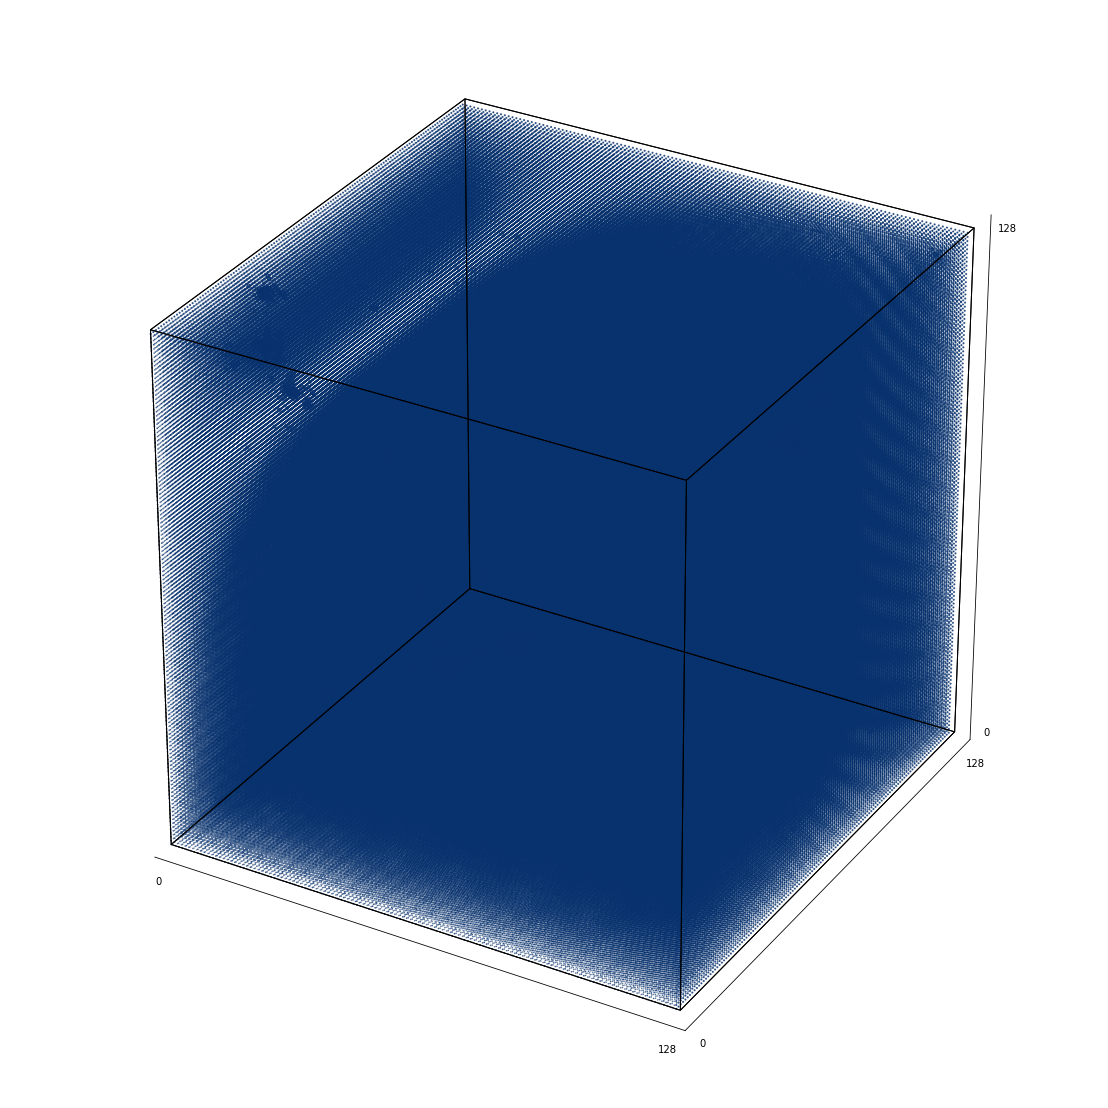

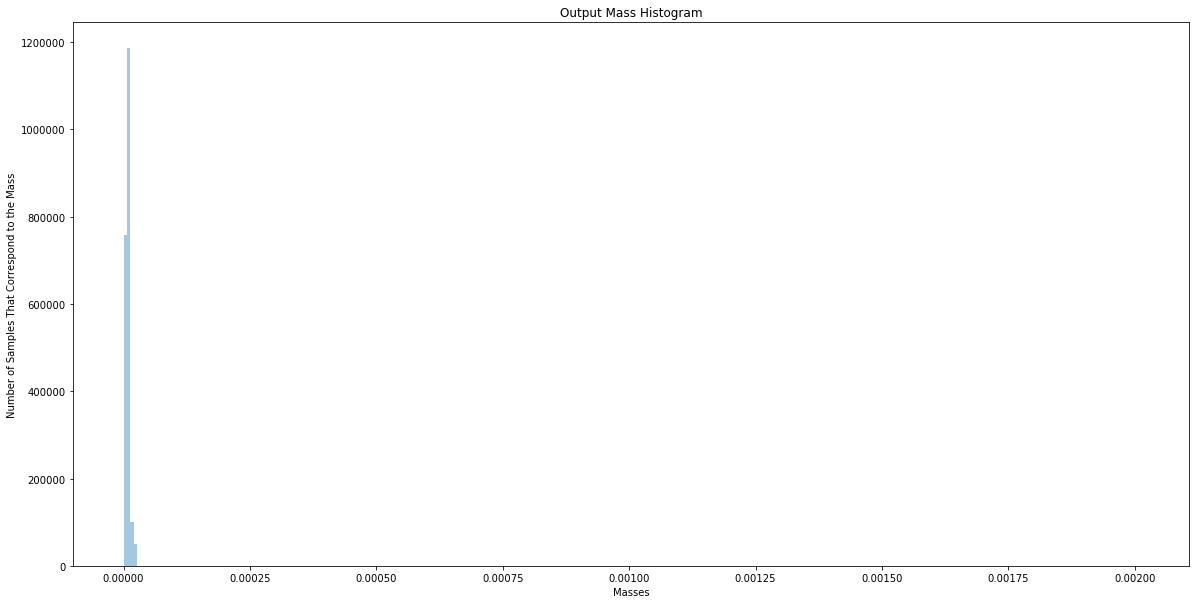

Output mass sum (reconstructed batch): 17.70427
MSE Loss = tensor(3938600615936., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.2261, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 10 [0/256 (0%)]	Loss: 246162538496.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4849.968
CONV 1 OUT SUM = -11964.566
RELU 1 OUT SUM = 2749.272
MAX UNPOOL 1 OUT SUM = 2749.2717
CONV 2 OUT SUM = -117286.23
RELU 2 OUT SUM = 22682.066
MAX UNPOOL 2 OUT SUM = 22682.055
CONV 3 OUT SUM = -18253.178
RELU 3 OUT SUM = 299.67465
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(904121745408., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1440, device='cuda:0', grad_fn=<DivBackward0>)
Train

Train Epoch: 10 [160/256 (62%)]	Loss: 212508049408.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4758.8066
CONV 1 OUT SUM = -11873.09
RELU 1 OUT SUM = 2796.429
MAX UNPOOL 1 OUT SUM = 2796.4294
CONV 2 OUT SUM = -121188.61
RELU 2 OUT SUM = 23477.31
MAX UNPOOL 2 OUT SUM = 23477.305
CONV 3 OUT SUM = -18054.197
RELU 3 OUT SUM = 313.21365
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1352994783232., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1471, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 10 [176/256 (69%)]	Loss: 84562173952.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])


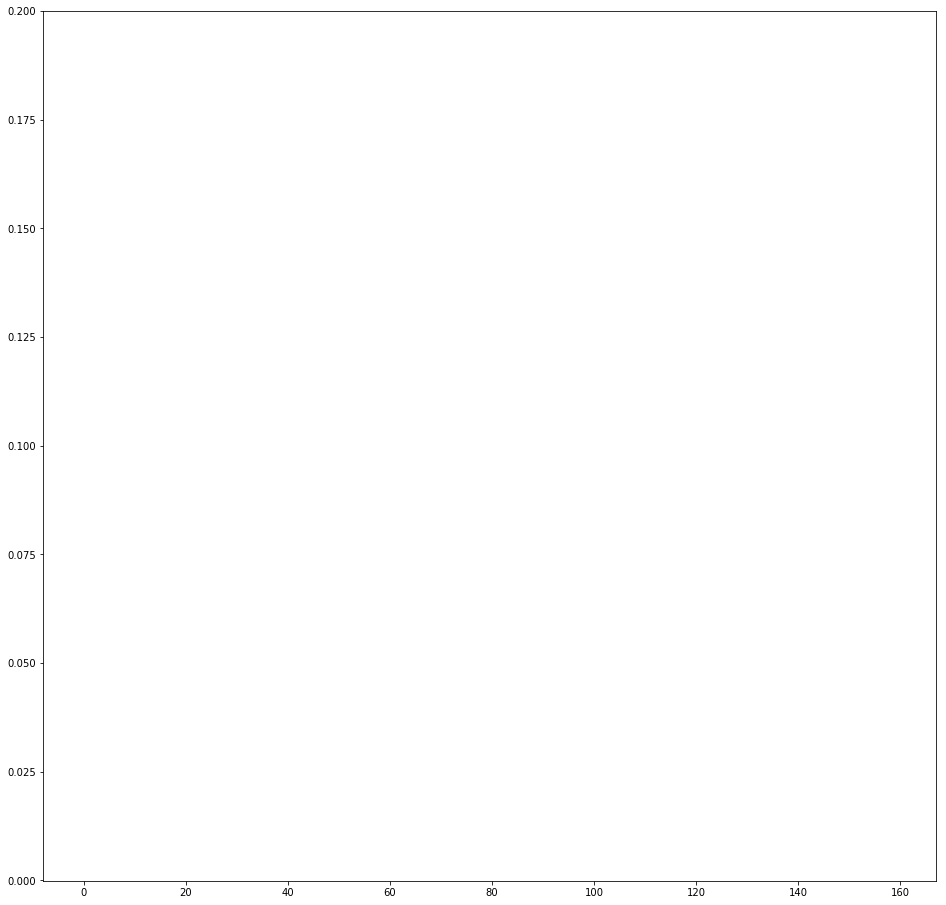

Epoch = 11 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4768.0786
CONV 1 OUT SUM = -12008.197
RELU 1 OUT SUM = 2803.7354
MAX UNPOOL 1 OUT SUM = 2803.735
CONV 2 OUT SUM = -121349.97
RELU 2 OUT SUM = 23478.67
MAX UNPOOL 2 OUT SUM = 23478.646
CONV 3 OUT SUM = -25318.584
RELU 3 OUT SUM = 400.1771
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(3176759820288., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1755, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 11 [0/256 (0%)]	Loss: 198547488768.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECOD

MAX UNPOOL 2 OUT SUM = 24534.62
CONV 3 OUT SUM = -22575.043
RELU 3 OUT SUM = 377.7796
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1563089698816., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1716, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 11 [160/256 (62%)]	Loss: 97693106176.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4433.3613
CONV 1 OUT SUM = -11302.772
RELU 1 OUT SUM = 2746.9087
MAX UNPOOL 1 OUT SUM = 2746.9082
CONV 2 OUT SUM = -125770.695
RELU 2 OUT SUM = 24501.691
MAX UNPOOL 2 OUT SUM = 24501.738
CONV 3 OUT SUM = -23623.723
RELU 3 OUT SUM = 384.71878
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.S

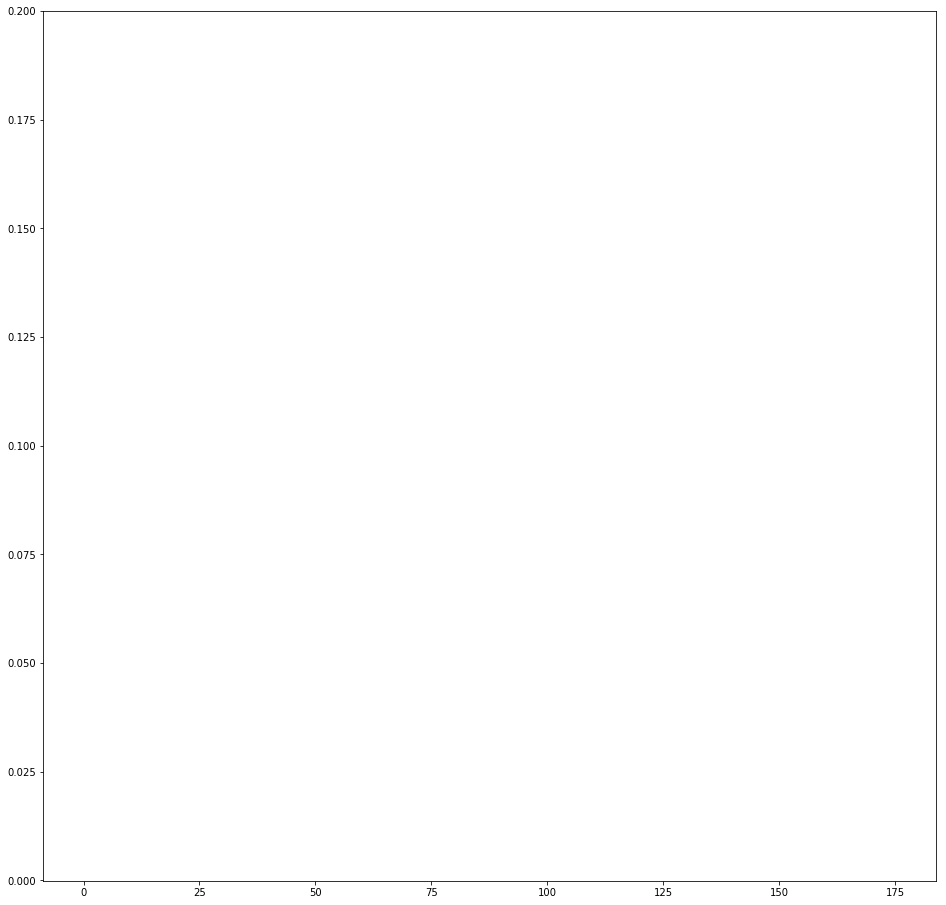

Epoch = 12 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5134.0454
CONV 1 OUT SUM = -13318.665
RELU 1 OUT SUM = 3169.6953
MAX UNPOOL 1 OUT SUM = 3169.6953
CONV 2 OUT SUM = -129078.71
RELU 2 OUT SUM = 24728.738
MAX UNPOOL 2 OUT SUM = 24728.799
CONV 3 OUT SUM = -26428.61
RELU 3 OUT SUM = 420.33008
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(818501582848., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1222, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 12 [0/256 (0%)]	Loss: 51156348928.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECOD

MAX UNPOOL 2 OUT SUM = 25393.172
CONV 3 OUT SUM = -24442.988
RELU 3 OUT SUM = 407.095
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2101738209280., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1507, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 12 [160/256 (62%)]	Loss: 131358638080.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5170.374
CONV 1 OUT SUM = -13720.525
RELU 1 OUT SUM = 3291.1392
MAX UNPOOL 1 OUT SUM = 3291.14
CONV 2 OUT SUM = -133171.83
RELU 2 OUT SUM = 25388.406
MAX UNPOOL 2 OUT SUM = 25388.42
CONV 3 OUT SUM = -25254.375
RELU 3 OUT SUM = 414.37787
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size(

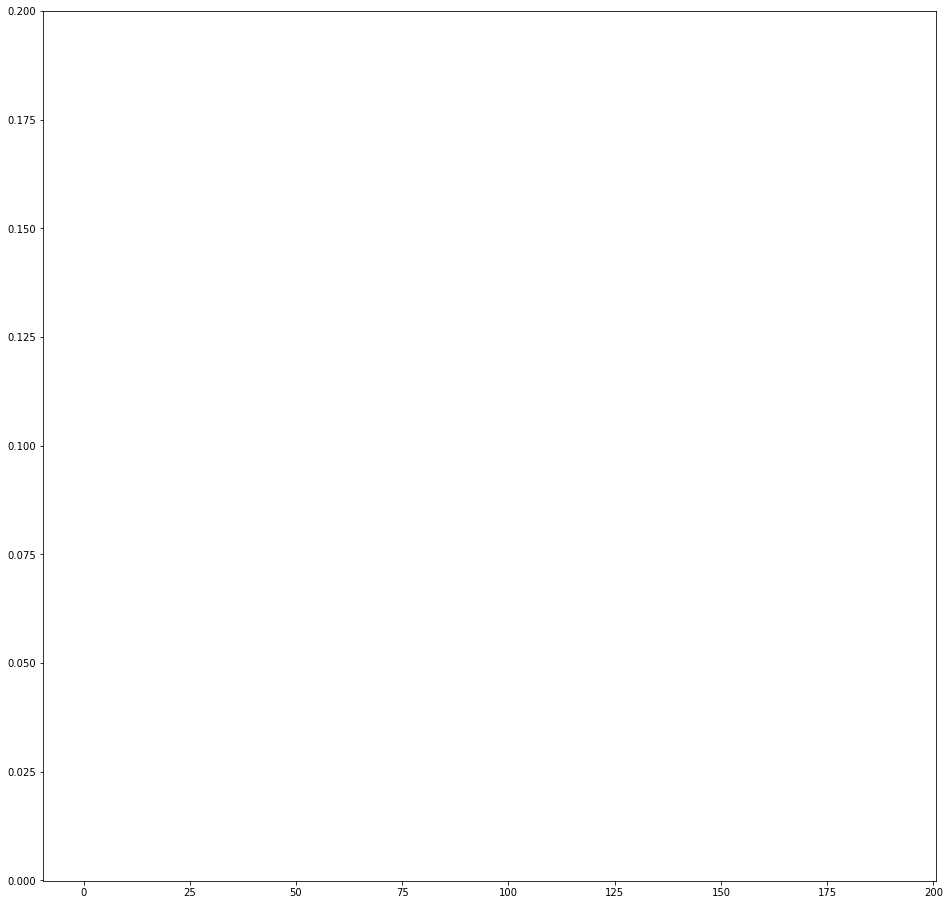

Epoch = 13 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5081.955
CONV 1 OUT SUM = -13451.85
RELU 1 OUT SUM = 3290.1155
MAX UNPOOL 1 OUT SUM = 3290.1157
CONV 2 OUT SUM = -134191.53
RELU 2 OUT SUM = 25613.322
MAX UNPOOL 2 OUT SUM = 25613.303
CONV 3 OUT SUM = -28931.54
RELU 3 OUT SUM = 471.24255
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(3253669724160., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1541, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 13 [0/256 (0%)]	Loss: 203354357760.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECOD

MAX UNPOOL 2 OUT SUM = 26527.293
CONV 3 OUT SUM = -28473.896
RELU 3 OUT SUM = 456.08307
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1641374679040., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1488, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 13 [160/256 (62%)]	Loss: 102585917440.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5202.635
CONV 1 OUT SUM = -13756.943
RELU 1 OUT SUM = 3518.4575
MAX UNPOOL 1 OUT SUM = 3518.4587
CONV 2 OUT SUM = -139779.89
RELU 2 OUT SUM = 26744.838
MAX UNPOOL 2 OUT SUM = 26744.791
CONV 3 OUT SUM = -27181.643
RELU 3 OUT SUM = 437.49557
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.

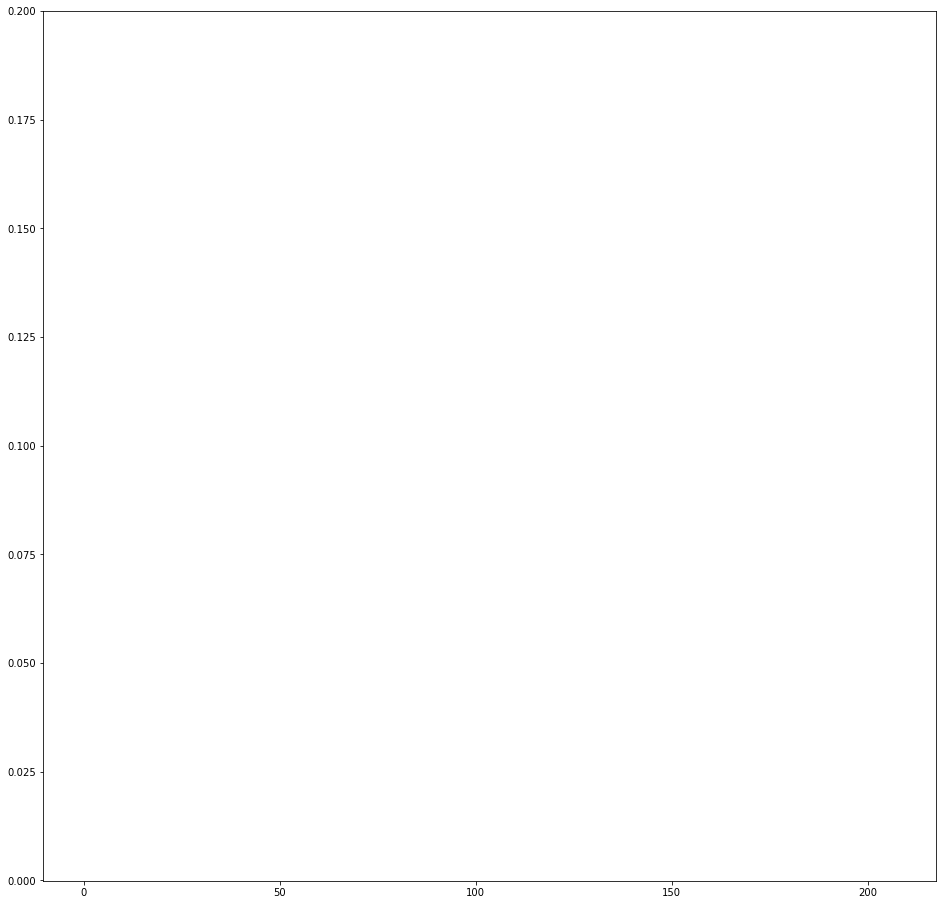

Epoch = 14 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5545.643
CONV 1 OUT SUM = -14863.488
RELU 1 OUT SUM = 3796.8403
MAX UNPOOL 1 OUT SUM = 3796.8394
CONV 2 OUT SUM = -141464.55
RELU 2 OUT SUM = 26840.479
MAX UNPOOL 2 OUT SUM = 26840.479
CONV 3 OUT SUM = -31799.893
RELU 3 OUT SUM = 513.25757
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2393743818752., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1046, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 14 [0/256 (0%)]	Loss: 149608988672.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DEC

MAX UNPOOL 2 OUT SUM = 27330.344
CONV 3 OUT SUM = -35264.203
RELU 3 OUT SUM = 552.04724
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(3314936971264., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1620, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 14 [160/256 (62%)]	Loss: 207183560704.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4671.9844
CONV 1 OUT SUM = -12530.819
RELU 1 OUT SUM = 3337.8838
MAX UNPOOL 1 OUT SUM = 3337.8853
CONV 2 OUT SUM = -141951.17
RELU 2 OUT SUM = 27203.75
MAX UNPOOL 2 OUT SUM = 27203.783
CONV 3 OUT SUM = -36750.055
RELU 3 OUT SUM = 566.67035
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.

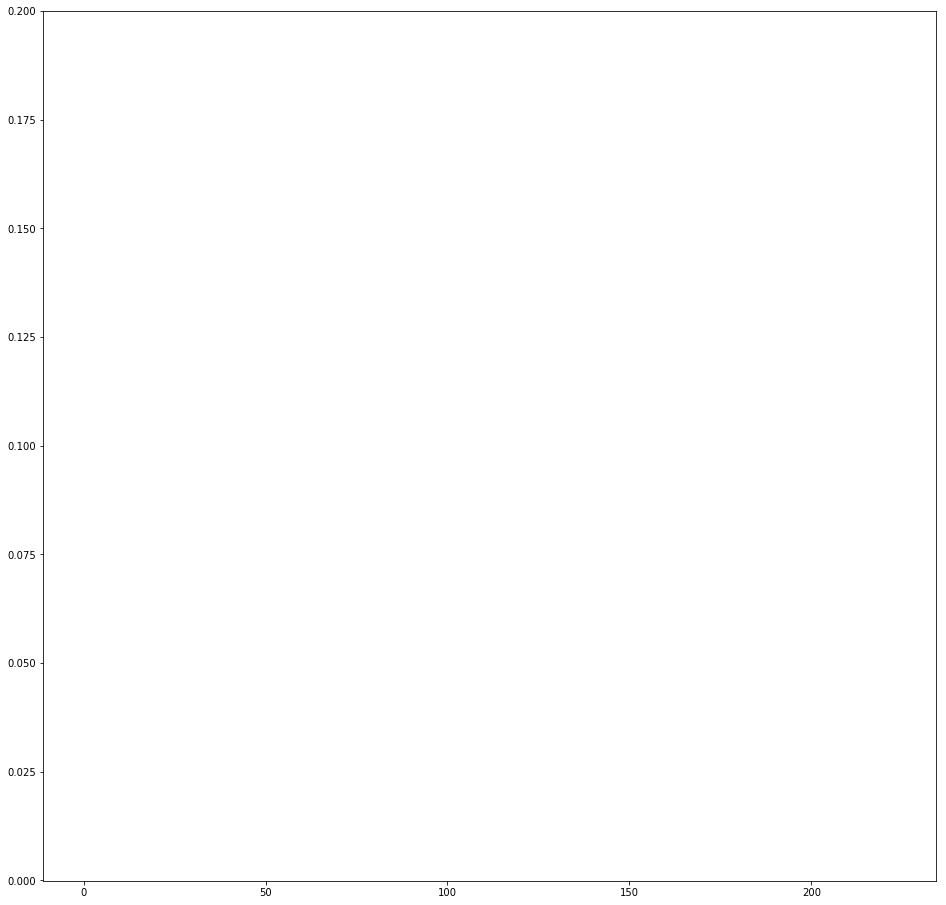

Epoch = 15 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5234.3726
CONV 1 OUT SUM = -14075.972
RELU 1 OUT SUM = 3750.2925
MAX UNPOOL 1 OUT SUM = 3750.2925
CONV 2 OUT SUM = -146307.69
RELU 2 OUT SUM = 27866.055
MAX UNPOOL 2 OUT SUM = 27865.986
CONV 3 OUT SUM = -30249.04
RELU 3 OUT SUM = 483.6589
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)


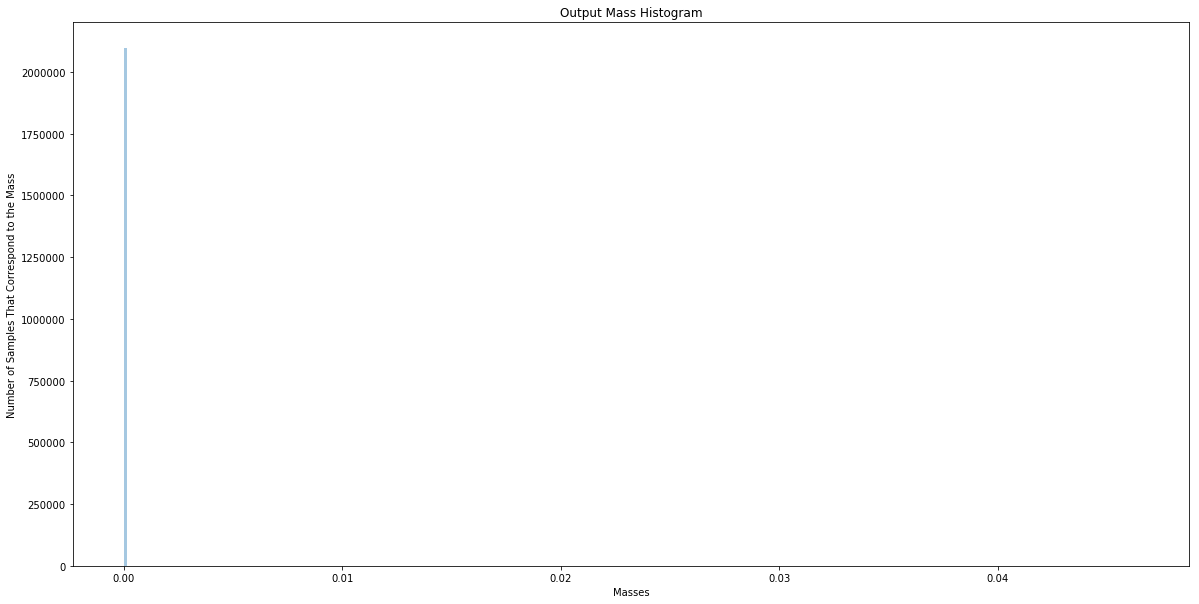

Output mass sum (original): 0.2722131
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])


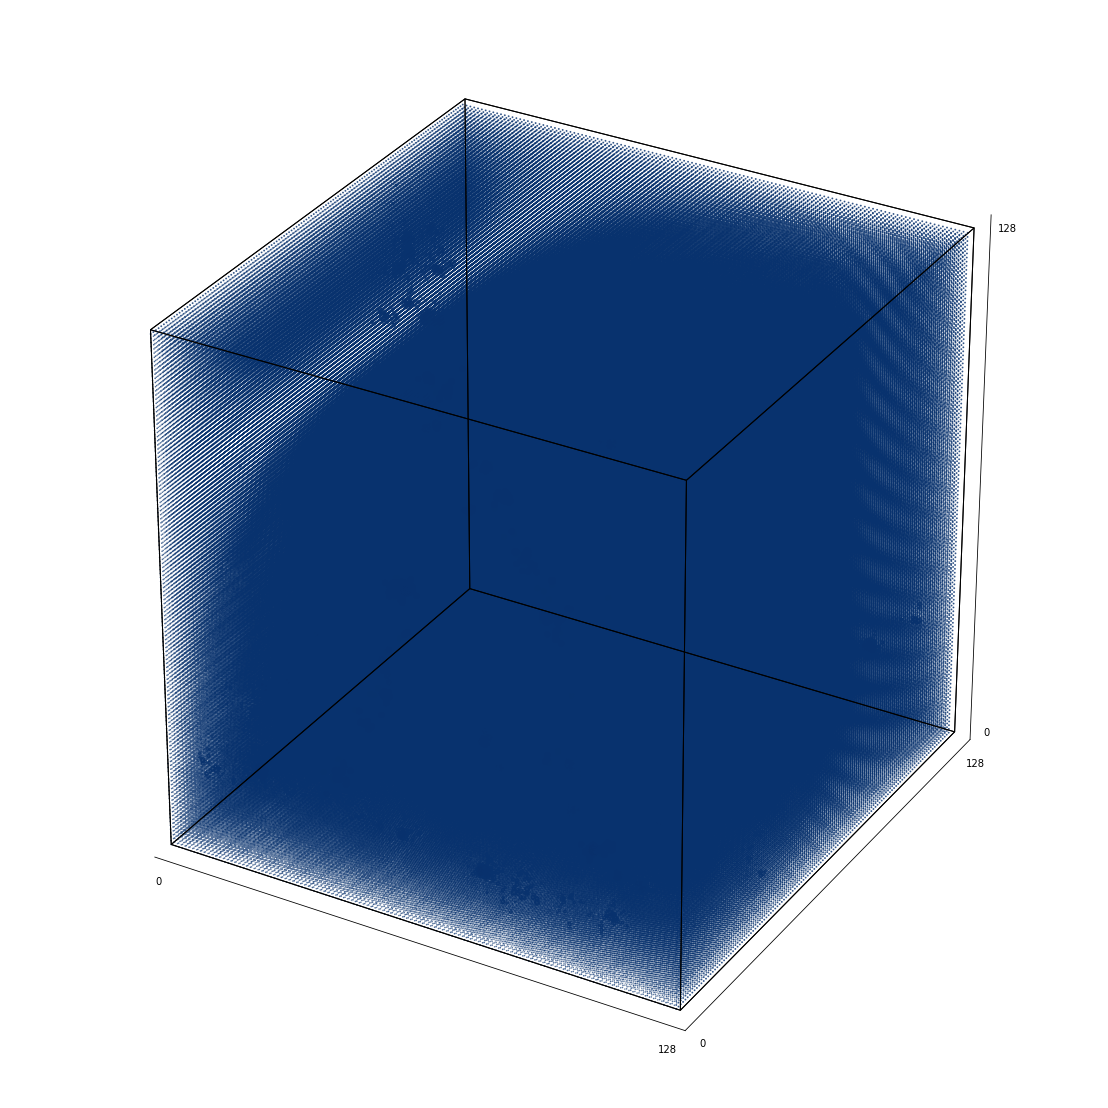

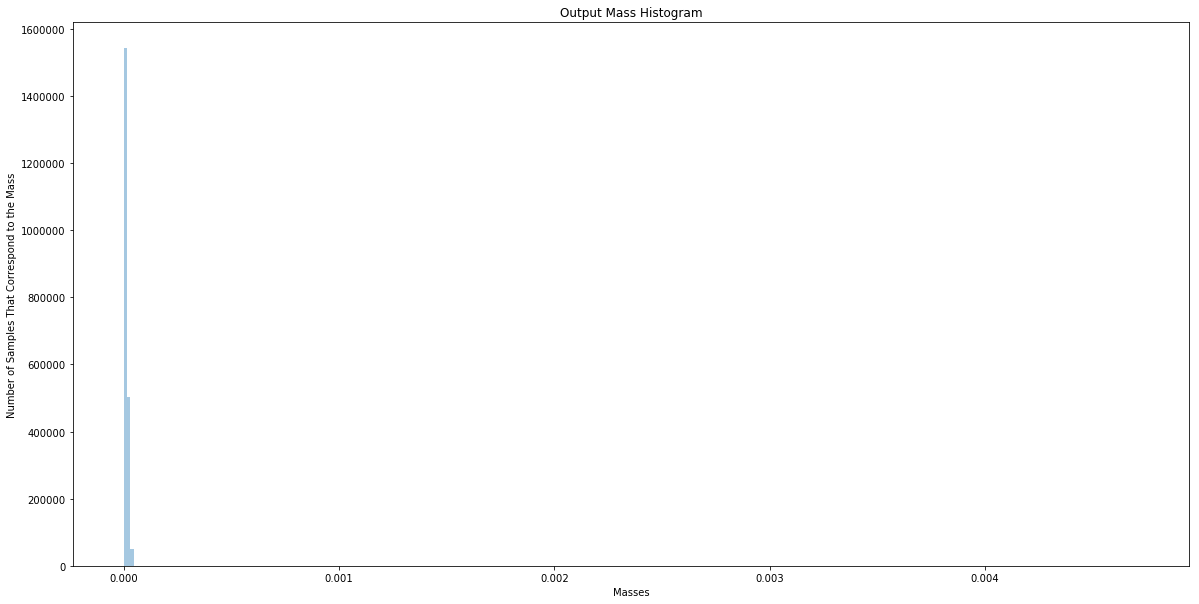

Output mass sum (reconstructed batch): 29.432438
MSE Loss = tensor(1748827242496., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1295, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 15 [0/256 (0%)]	Loss: 109301702656.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5200.67
CONV 1 OUT SUM = -14042.82
RELU 1 OUT SUM = 3724.8025
MAX UNPOOL 1 OUT SUM = 3724.8015
CONV 2 OUT SUM = -147320.86
RELU 2 OUT SUM = 28170.979
MAX UNPOOL 2 OUT SUM = 28170.959
CONV 3 OUT SUM = -26852.543
RELU 3 OUT SUM = 439.55936
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1876036812800., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1331, device='cuda:0', grad_fn=<DivBackward0>)
Trai

Train Epoch: 15 [160/256 (62%)]	Loss: 25136343040.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4982.7974
CONV 1 OUT SUM = -13474.048
RELU 1 OUT SUM = 3700.7756
MAX UNPOOL 1 OUT SUM = 3700.7744
CONV 2 OUT SUM = -148785.73
RELU 2 OUT SUM = 28442.62
MAX UNPOOL 2 OUT SUM = 28442.635
CONV 3 OUT SUM = -38400.57
RELU 3 OUT SUM = 593.84216
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(589049364480., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1536, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 15 [176/256 (69%)]	Loss: 36815585280.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
t

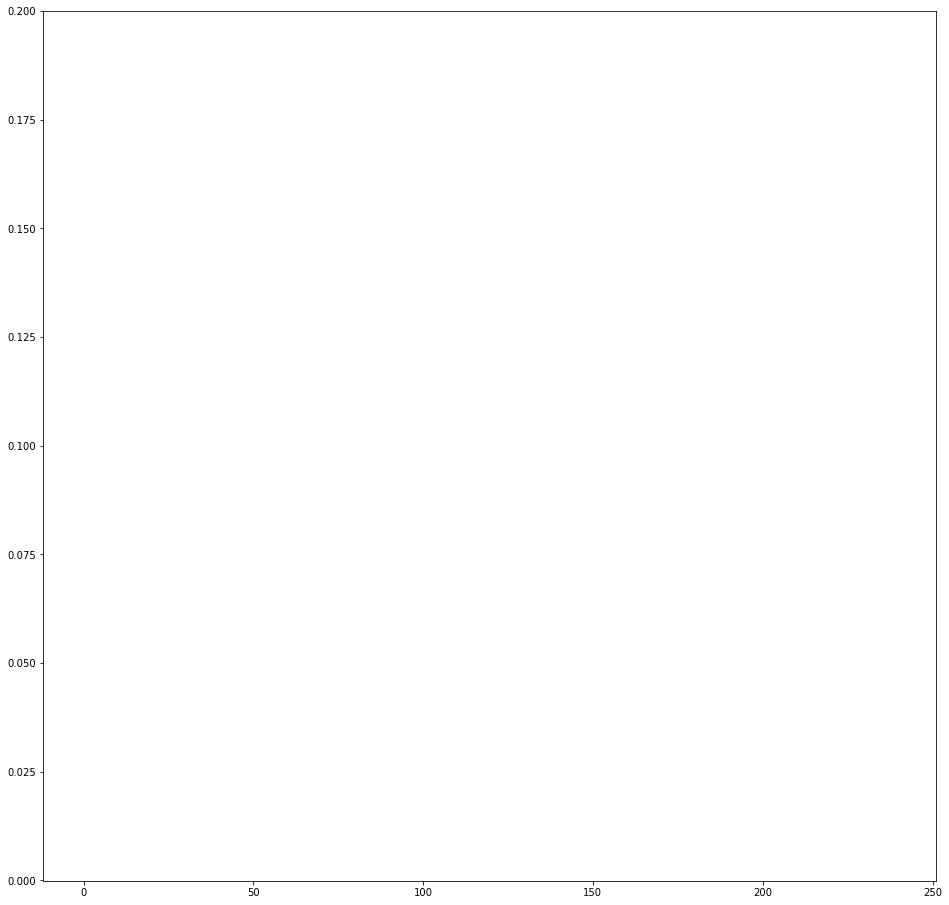

Epoch = 16 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5684.301
CONV 1 OUT SUM = -15324.275
RELU 1 OUT SUM = 4207.1885
MAX UNPOOL 1 OUT SUM = 4207.1885
CONV 2 OUT SUM = -155165.34
RELU 2 OUT SUM = 29669.148
MAX UNPOOL 2 OUT SUM = 29669.184
CONV 3 OUT SUM = -25333.373
RELU 3 OUT SUM = 454.23026
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1689442058240., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1270, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 16 [0/256 (0%)]	Loss: 105590128640.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DEC

MAX UNPOOL 2 OUT SUM = 30392.398
CONV 3 OUT SUM = -30950.363
RELU 3 OUT SUM = 508.72485
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(942564573184., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1568, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 16 [160/256 (62%)]	Loss: 58910285824.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5492.457
CONV 1 OUT SUM = -15280.03
RELU 1 OUT SUM = 4158.1733
MAX UNPOOL 1 OUT SUM = 4158.174
CONV 2 OUT SUM = -158065.08
RELU 2 OUT SUM = 30277.69
MAX UNPOOL 2 OUT SUM = 30277.684
CONV 3 OUT SUM = -33291.324
RELU 3 OUT SUM = 539.626
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([1

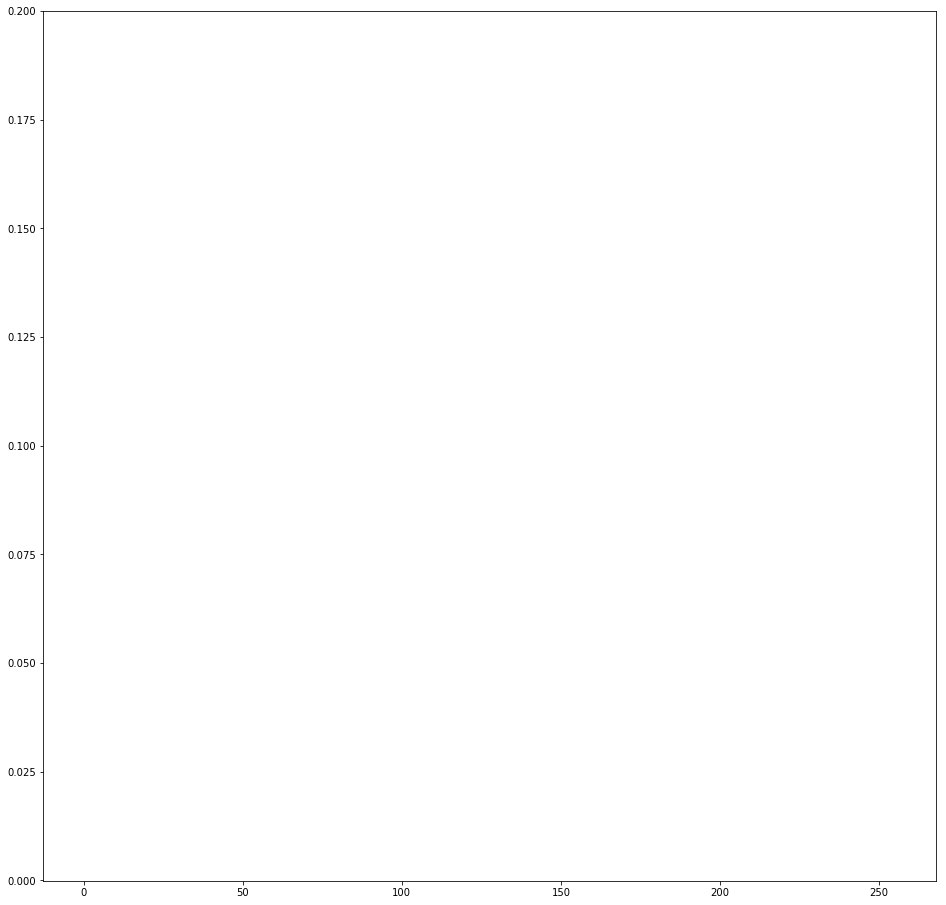

Epoch = 17 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5513.047
CONV 1 OUT SUM = -15512.383
RELU 1 OUT SUM = 4127.0933
MAX UNPOOL 1 OUT SUM = 4127.0933
CONV 2 OUT SUM = -158430.11
RELU 2 OUT SUM = 30156.889
MAX UNPOOL 2 OUT SUM = 30156.863
CONV 3 OUT SUM = -38536.355
RELU 3 OUT SUM = 594.3135
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1163214192640., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1543, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 17 [0/256 (0%)]	Loss: 72700887040.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECOD

MAX UNPOOL 2 OUT SUM = 30511.031
CONV 3 OUT SUM = -42899.25
RELU 3 OUT SUM = 660.6312
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(940472860672., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1579, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 17 [160/256 (62%)]	Loss: 58779553792.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 4608.5537
CONV 1 OUT SUM = -13346.65
RELU 1 OUT SUM = 3649.768
MAX UNPOOL 1 OUT SUM = 3649.7678
CONV 2 OUT SUM = -158983.81
RELU 2 OUT SUM = 30432.613
MAX UNPOOL 2 OUT SUM = 30432.635
CONV 3 OUT SUM = -44059.36
RELU 3 OUT SUM = 679.399
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16

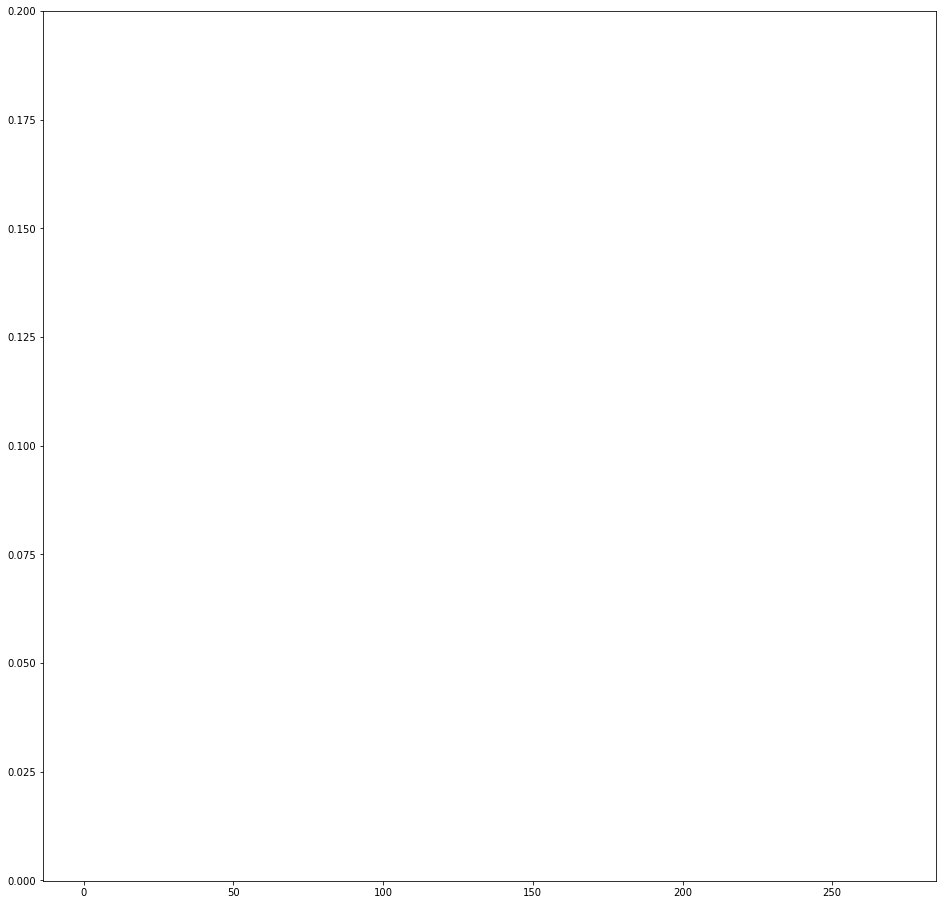

Epoch = 18 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5996.2456
CONV 1 OUT SUM = -17508.281
RELU 1 OUT SUM = 4598.1426
MAX UNPOOL 1 OUT SUM = 4598.142
CONV 2 OUT SUM = -165743.72
RELU 2 OUT SUM = 31370.033
MAX UNPOOL 2 OUT SUM = 31370.055
CONV 3 OUT SUM = -33674.586
RELU 3 OUT SUM = 547.0455
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(424865497088., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1652, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 18 [0/256 (0%)]	Loss: 26554093568.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE

MAX UNPOOL 2 OUT SUM = 31576.807
CONV 3 OUT SUM = -29566.297
RELU 3 OUT SUM = 508.37808
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(4783260303360., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1720, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 18 [160/256 (62%)]	Loss: 298953768960.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5184.7256
CONV 1 OUT SUM = -14944.505
RELU 1 OUT SUM = 4081.5554
MAX UNPOOL 1 OUT SUM = 4081.5554
CONV 2 OUT SUM = -167543.66
RELU 2 OUT SUM = 31779.707
MAX UNPOOL 2 OUT SUM = 31779.768
CONV 3 OUT SUM = -28181.87
RELU 3 OUT SUM = 479.43747
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.

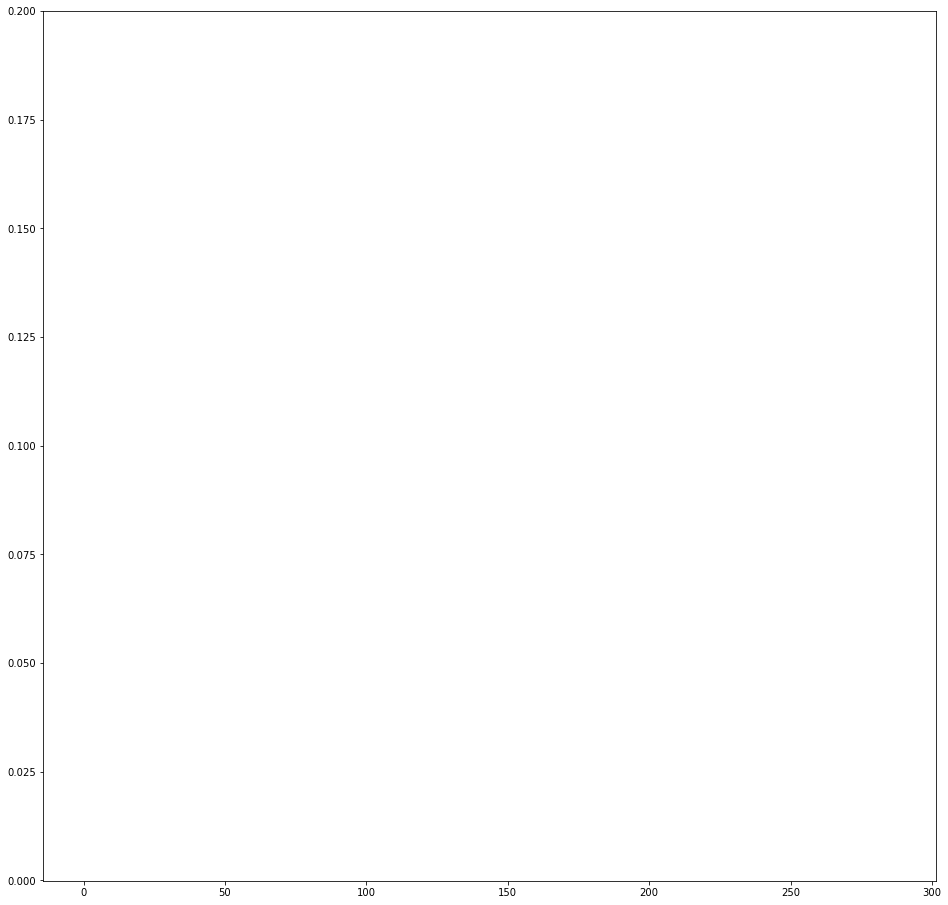

Epoch = 19 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5143.8193
CONV 1 OUT SUM = -14888.266
RELU 1 OUT SUM = 4169.072
MAX UNPOOL 1 OUT SUM = 4169.0723
CONV 2 OUT SUM = -167227.0
RELU 2 OUT SUM = 31432.695
MAX UNPOOL 2 OUT SUM = 31432.676
CONV 3 OUT SUM = -42472.113
RELU 3 OUT SUM = 650.2152
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(857944752128., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1264, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 19 [0/256 (0%)]	Loss: 53621547008.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE 

MAX UNPOOL 2 OUT SUM = 32679.05
CONV 3 OUT SUM = -35458.215
RELU 3 OUT SUM = 577.5347
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1776422486016., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1896, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 19 [160/256 (62%)]	Loss: 111026405376.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5131.086
CONV 1 OUT SUM = -14825.273
RELU 1 OUT SUM = 4485.4883
MAX UNPOOL 1 OUT SUM = 4485.489
CONV 2 OUT SUM = -172390.06
RELU 2 OUT SUM = 32521.195
MAX UNPOOL 2 OUT SUM = 32521.154
CONV 3 OUT SUM = -40522.29
RELU 3 OUT SUM = 632.73615
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size

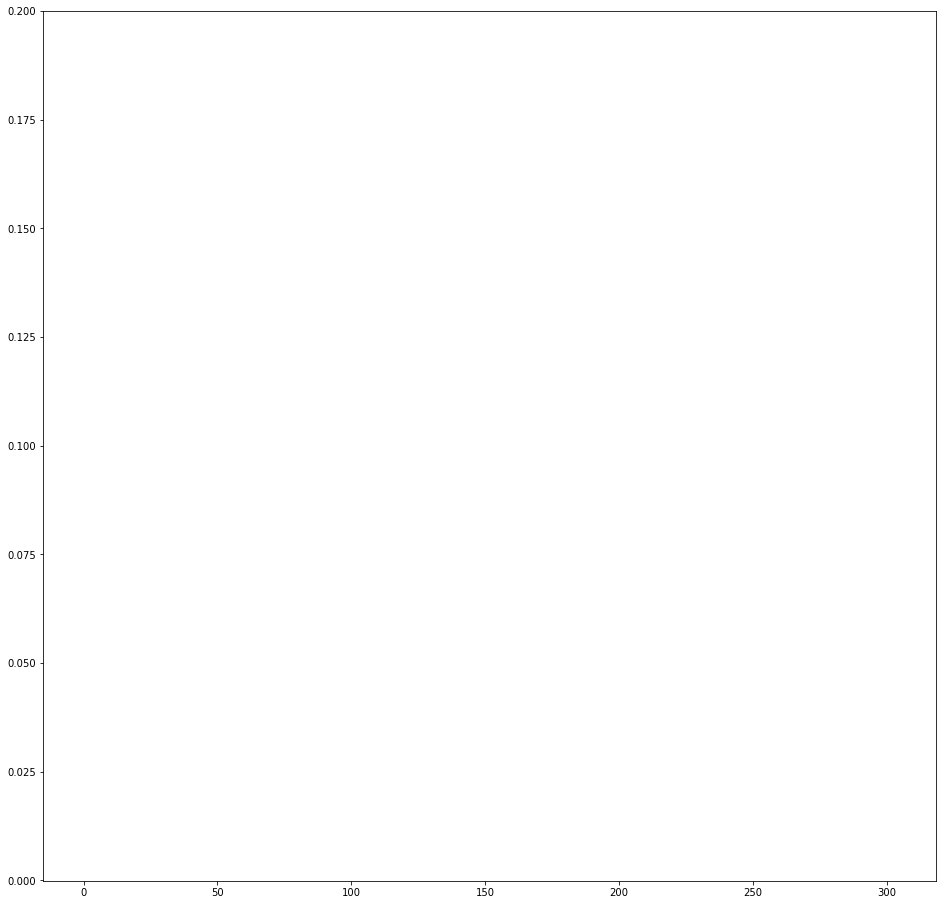

Epoch = 20 / 20
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5906.756
CONV 1 OUT SUM = -17200.852
RELU 1 OUT SUM = 5109.386
MAX UNPOOL 1 OUT SUM = 5109.3853
CONV 2 OUT SUM = -175781.3
RELU 2 OUT SUM = 32921.77
MAX UNPOOL 2 OUT SUM = 32921.766
CONV 3 OUT SUM = -46207.734
RELU 3 OUT SUM = 713.91547
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)


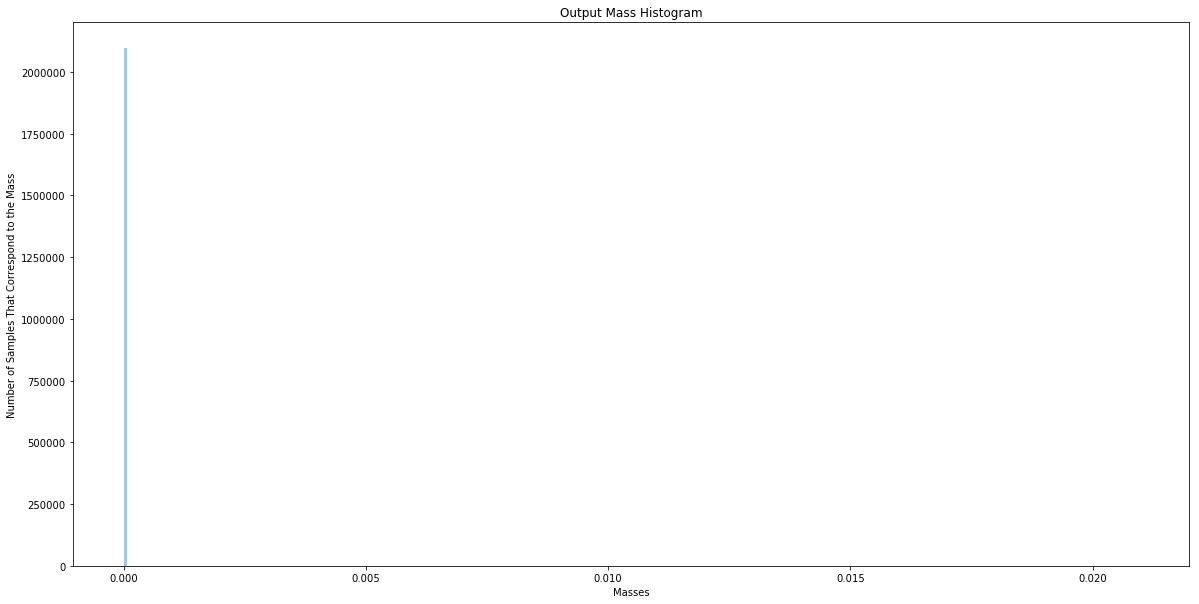

Output mass sum (original): 0.30862802
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])


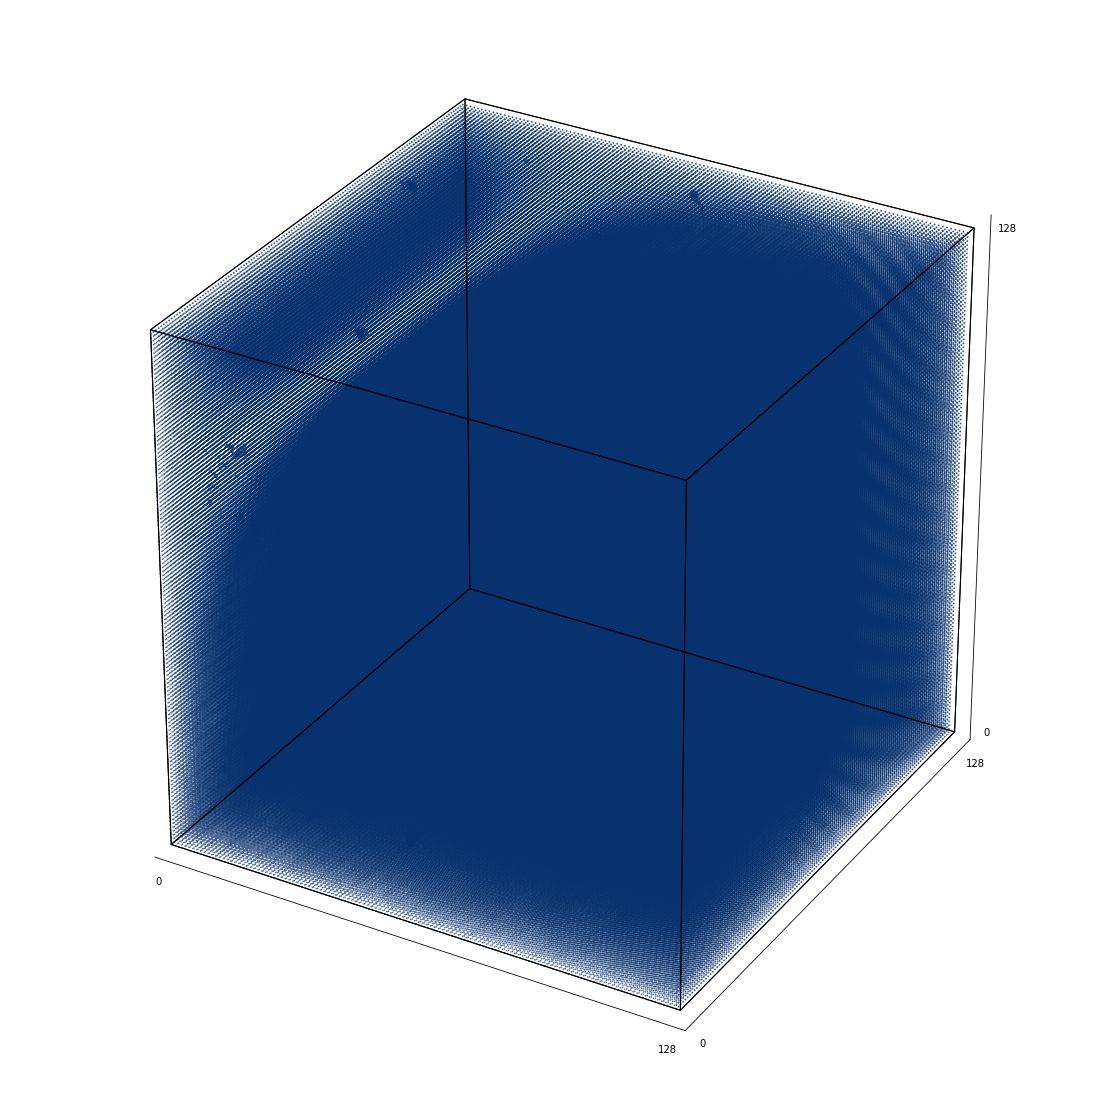

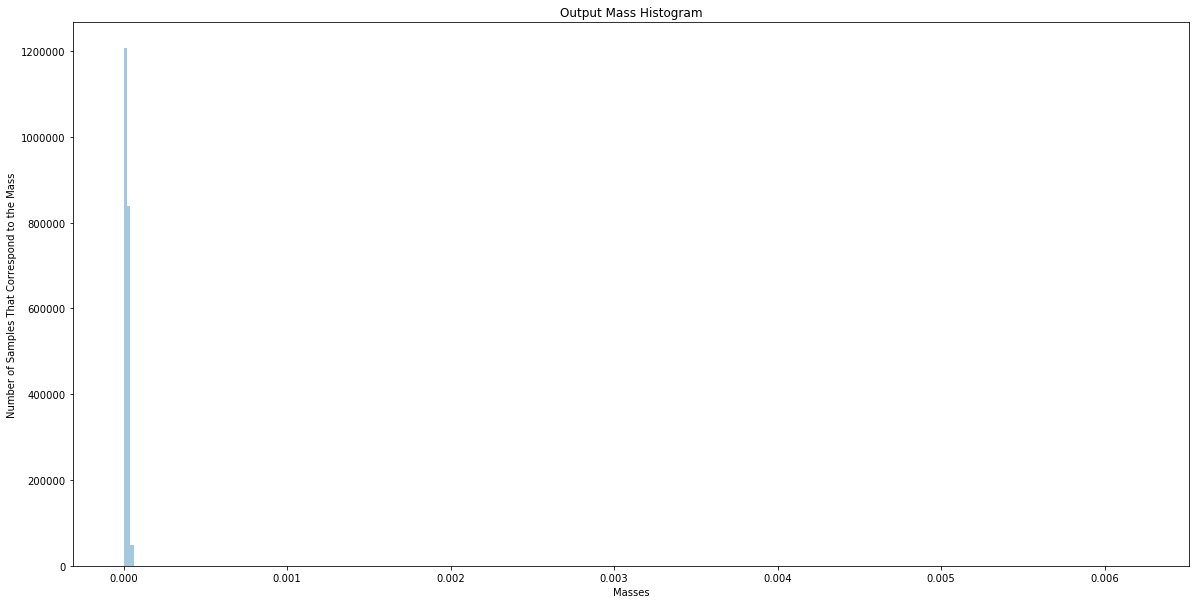

Output mass sum (reconstructed batch): 43.614006
MSE Loss = tensor(1599467814912., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1740, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 20 [0/256 (0%)]	Loss: 99966738432.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5848.924
CONV 1 OUT SUM = -16987.996
RELU 1 OUT SUM = 5064.558
MAX UNPOOL 1 OUT SUM = 5064.558
CONV 2 OUT SUM = -176533.77
RELU 2 OUT SUM = 33147.973
MAX UNPOOL 2 OUT SUM = 33147.992
CONV 3 OUT SUM = -43722.8
RELU 3 OUT SUM = 676.1525
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(1082905067520., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1682, device='cuda:0', grad_fn=<DivBackward0>)
Train Ep

Train Epoch: 20 [160/256 (62%)]	Loss: 92337250304.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 5598.999
CONV 1 OUT SUM = -16537.404
RELU 1 OUT SUM = 5038.7
MAX UNPOOL 1 OUT SUM = 5038.702
CONV 2 OUT SUM = -180670.39
RELU 2 OUT SUM = 33791.566
MAX UNPOOL 2 OUT SUM = 33791.59
CONV 3 OUT SUM = -35973.566
RELU 3 OUT SUM = 575.95605
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(2285226688512., device='cuda:0', grad_fn=<MulBackward>)
KLD Loss = tensor(0.1747, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 20 [176/256 (69%)]	Loss: 142826668032.000000000000
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
tor

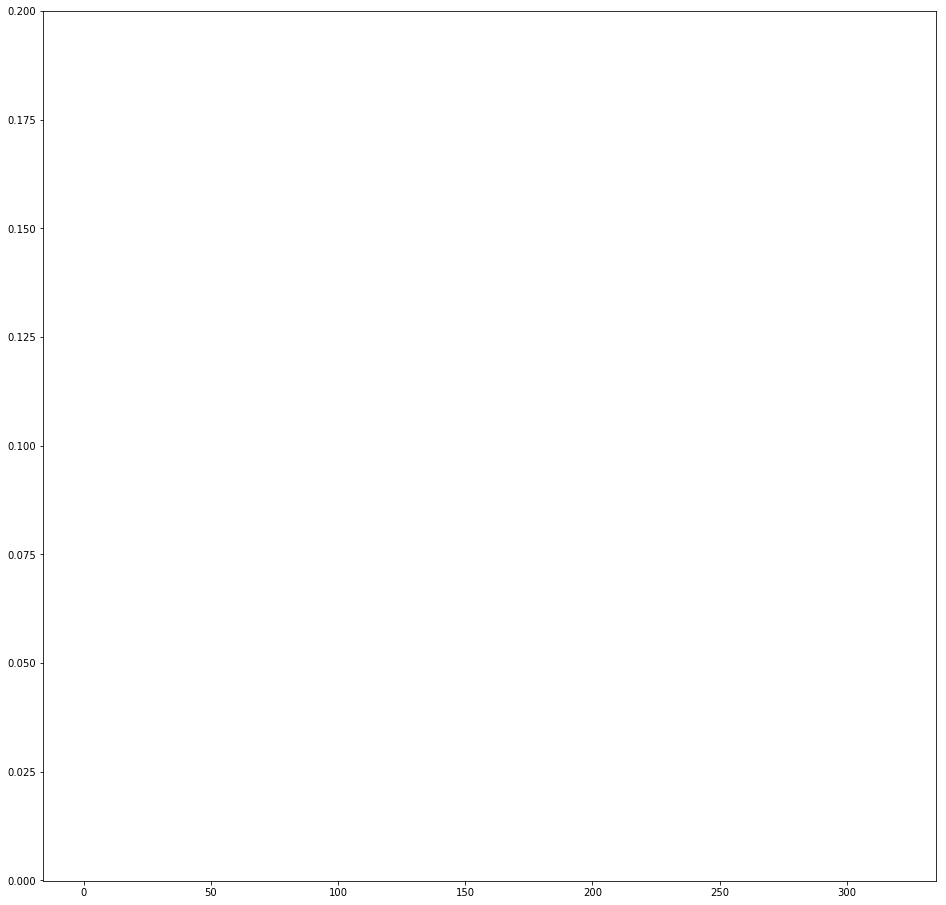

In [179]:
if __name__ == "__main__":
    
    loss_history = []
    #for epoch in range(1, args.epochs + 1):
    for epoch in range(1, epochs + 1):
        print("Epoch = " + str(epoch) + " / " + str(epochs))
        
        train(epoch)
        
        # Plotting Training Losses
        plt.figure(figsize=(16,16))
        plt.ylim(-0.0001,0.2)
        plt.plot(loss_history)
        plt.show()
        
#         test(epoch)
        
        
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')